<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [2]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2024-10-29 15:17:35--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2024-10-29 15:17:35--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: 'utils.py'

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2024-10-29 15:17:35 (36.9 MB/s) - 'utils.py' saved [2627/2627]



In [3]:
%run 'utils.py'

In [4]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [5]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2), # CONV1
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), # POOL1
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),  # CONV2
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), #POOL2
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2), #CONV3
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), #POOL3
            nn.Flatten(), # flatten the matrix 64x4x4 in a column vector
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),  # FC4
            nn.ReLU(),
            nn.Linear(1000, 10),   #FC4
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates wether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    
    global loss_plot 
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
    

#   <span style="color:green"> 2. Training from scratch of the model 

 ## <span style='color:gray'> 2.2 Network Learning

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.105s (0.105s)	Loss 2.3031 (2.3031)	Prec@1   7.8 (  7.8)	Prec@5  50.0 ( 50.0)


<Figure size 640x480 with 0 Axes>

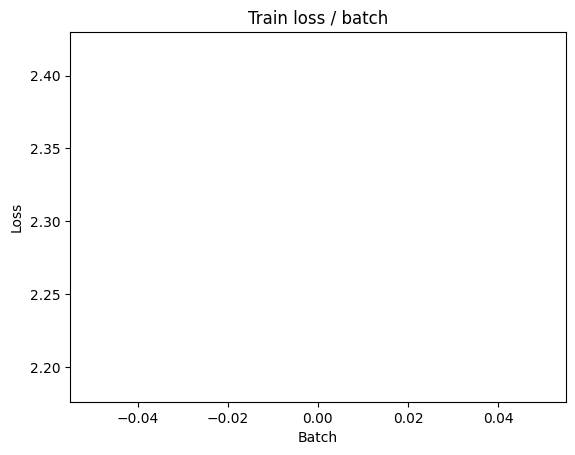

[TRAIN Batch 200/391]	Time 0.017s (0.015s)	Loss 2.2496 (2.2432)	Prec@1  17.2 ( 16.1)	Prec@5  56.2 ( 62.2)


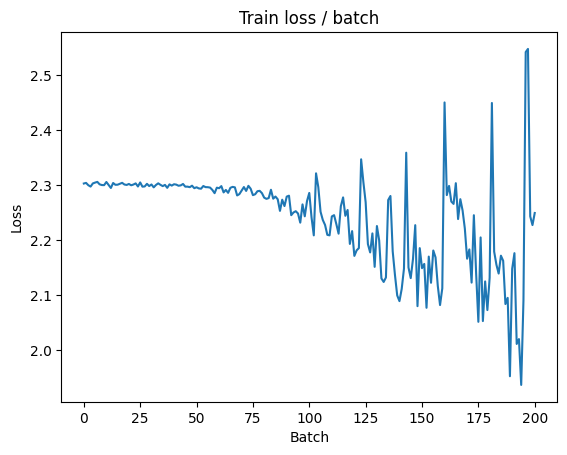


===============> Total time 5s	Avg loss 2.1434	Avg Prec@1 20.93 %	Avg Prec@5 69.55 %

[EVAL Batch 000/079]	Time 0.092s (0.092s)	Loss 1.8616 (1.8616)	Prec@1  32.8 ( 32.8)	Prec@5  85.2 ( 85.2)

===============> Total time 1s	Avg loss 1.8254	Avg Prec@1 32.84 %	Avg Prec@5 85.79 %



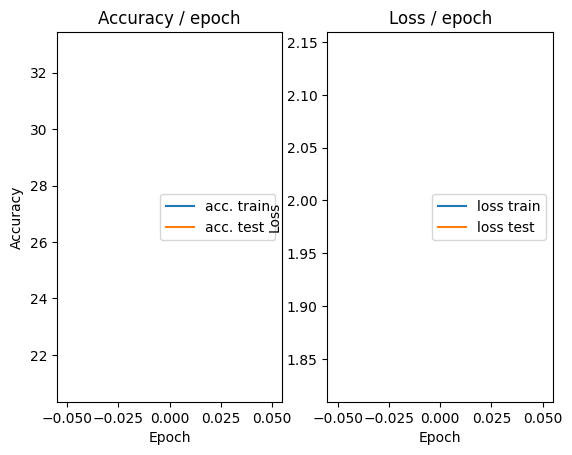

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.101s (0.101s)	Loss 1.9355 (1.9355)	Prec@1  25.8 ( 25.8)	Prec@5  83.6 ( 83.6)


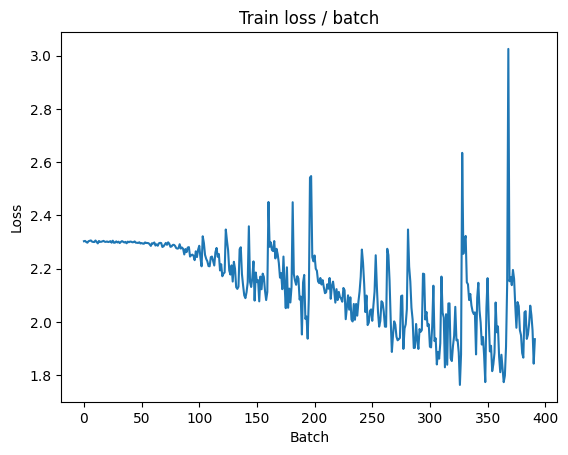

[TRAIN Batch 200/391]	Time 0.004s (0.015s)	Loss 1.4995 (1.7576)	Prec@1  46.1 ( 35.9)	Prec@5  93.0 ( 86.5)


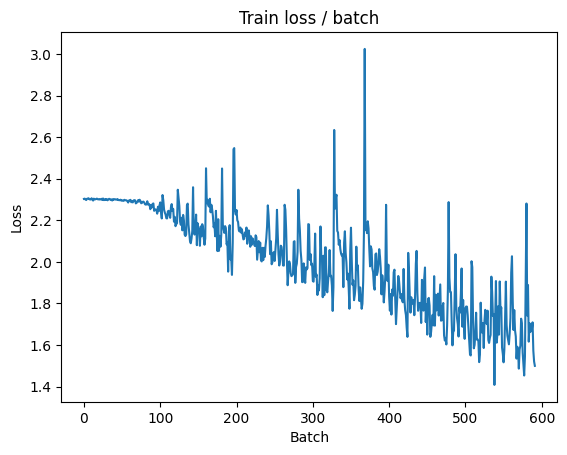


===============> Total time 6s	Avg loss 1.6712	Avg Prec@1 39.29 %	Avg Prec@5 88.29 %

[EVAL Batch 000/079]	Time 0.084s (0.084s)	Loss 1.4029 (1.4029)	Prec@1  57.0 ( 57.0)	Prec@5  89.8 ( 89.8)

===============> Total time 1s	Avg loss 1.4767	Avg Prec@1 47.06 %	Avg Prec@5 91.88 %



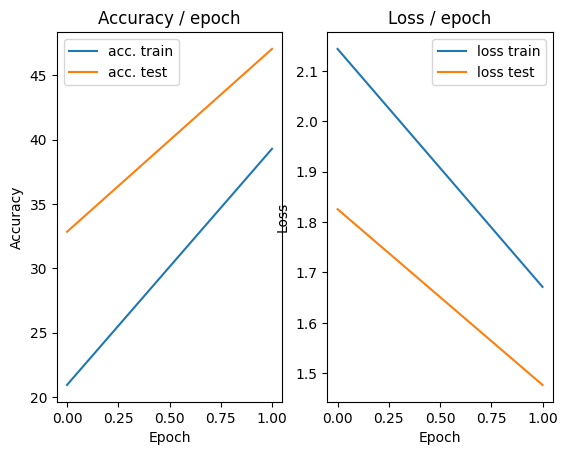

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.119s (0.119s)	Loss 1.4690 (1.4690)	Prec@1  46.1 ( 46.1)	Prec@5  93.8 ( 93.8)


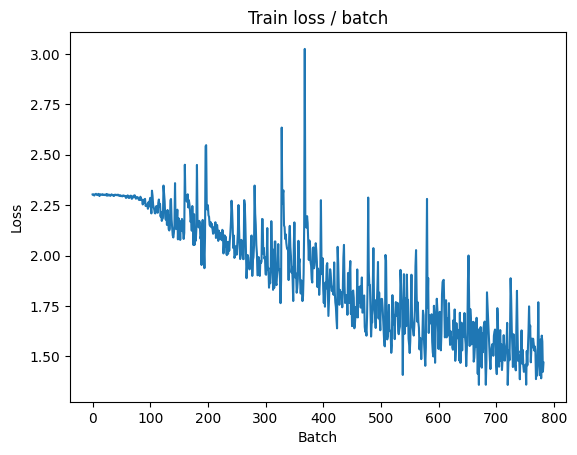

[TRAIN Batch 200/391]	Time 0.014s (0.014s)	Loss 1.3195 (1.4570)	Prec@1  49.2 ( 47.6)	Prec@5  93.8 ( 92.0)


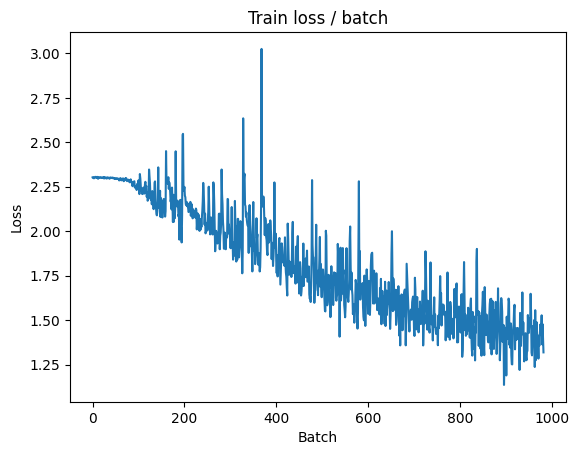


===============> Total time 5s	Avg loss 1.4105	Avg Prec@1 49.20 %	Avg Prec@5 92.65 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 1.2229 (1.2229)	Prec@1  60.9 ( 60.9)	Prec@5  95.3 ( 95.3)

===============> Total time 0s	Avg loss 1.4010	Avg Prec@1 49.22 %	Avg Prec@5 92.80 %



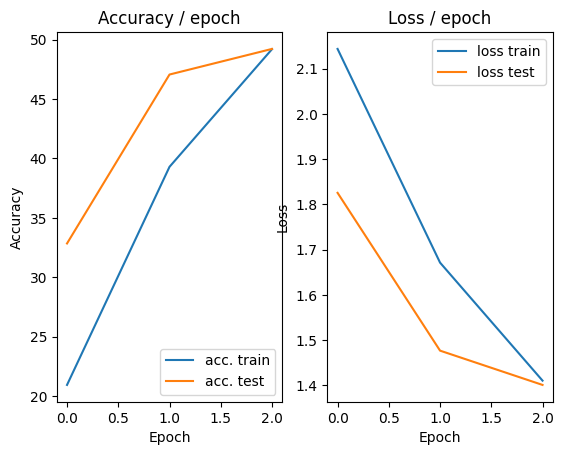

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.101s (0.101s)	Loss 1.3020 (1.3020)	Prec@1  50.8 ( 50.8)	Prec@5  93.8 ( 93.8)


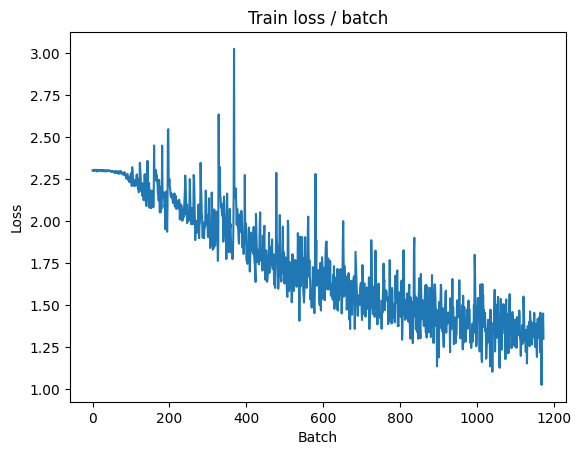

[TRAIN Batch 200/391]	Time 0.006s (0.014s)	Loss 1.1661 (1.2849)	Prec@1  55.5 ( 54.4)	Prec@5  98.4 ( 94.2)


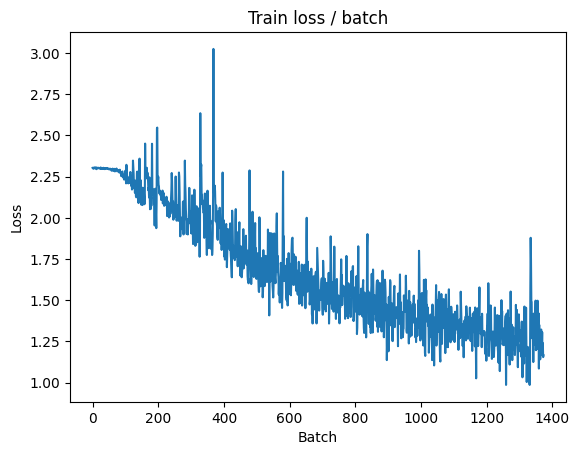


===============> Total time 5s	Avg loss 1.2466	Avg Prec@1 55.75 %	Avg Prec@5 94.64 %

[EVAL Batch 000/079]	Time 0.085s (0.085s)	Loss 1.0478 (1.0478)	Prec@1  65.6 ( 65.6)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1601	Avg Prec@1 58.58 %	Avg Prec@5 95.70 %



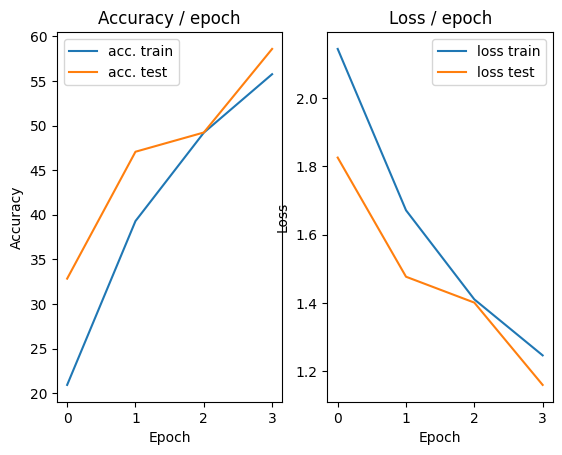

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.118s (0.118s)	Loss 1.0350 (1.0350)	Prec@1  60.9 ( 60.9)	Prec@5  96.9 ( 96.9)


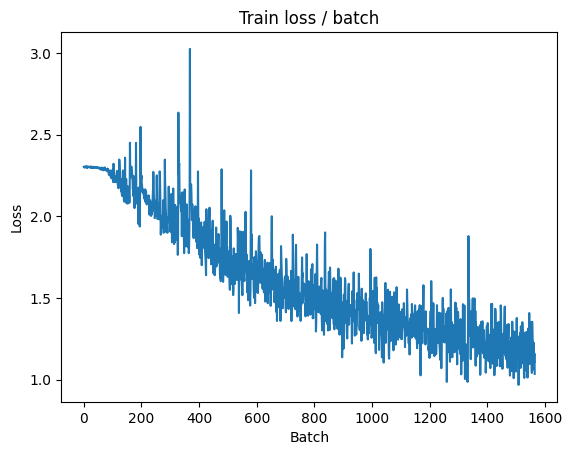

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 1.1622 (1.1185)	Prec@1  58.6 ( 60.1)	Prec@5  96.9 ( 96.0)


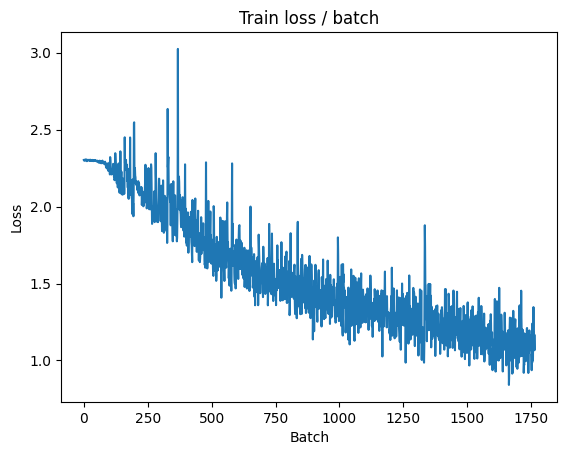


===============> Total time 5s	Avg loss 1.1044	Avg Prec@1 60.86 %	Avg Prec@5 96.06 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 0.9324 (0.9324)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.0730	Avg Prec@1 61.28 %	Avg Prec@5 96.20 %



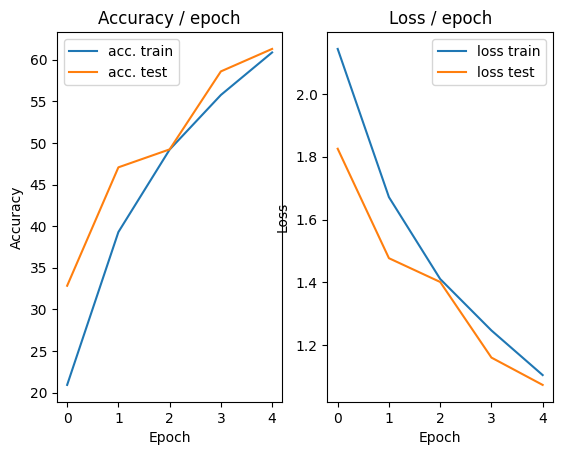

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.126s (0.126s)	Loss 0.9917 (0.9917)	Prec@1  62.5 ( 62.5)	Prec@5  96.9 ( 96.9)


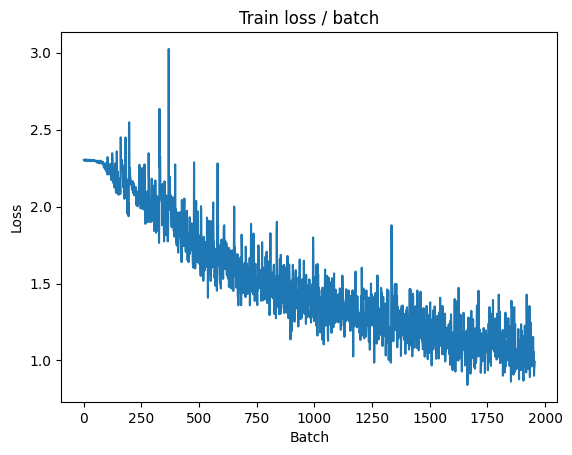

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.9558 (0.9956)	Prec@1  68.0 ( 64.6)	Prec@5  95.3 ( 96.8)


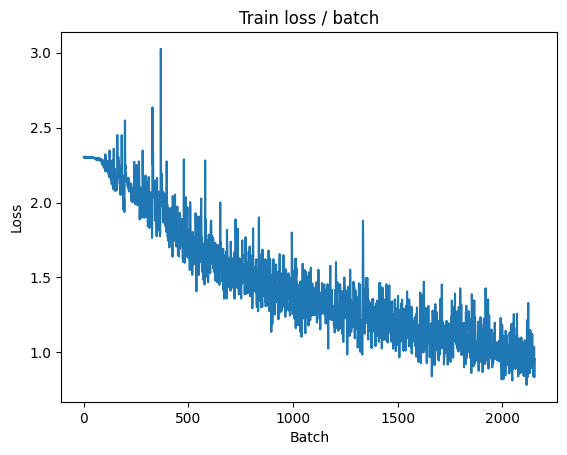


===============> Total time 5s	Avg loss 0.9795	Avg Prec@1 65.25 %	Avg Prec@5 96.90 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 1.1640 (1.1640)	Prec@1  64.1 ( 64.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1778	Avg Prec@1 59.22 %	Avg Prec@5 95.41 %



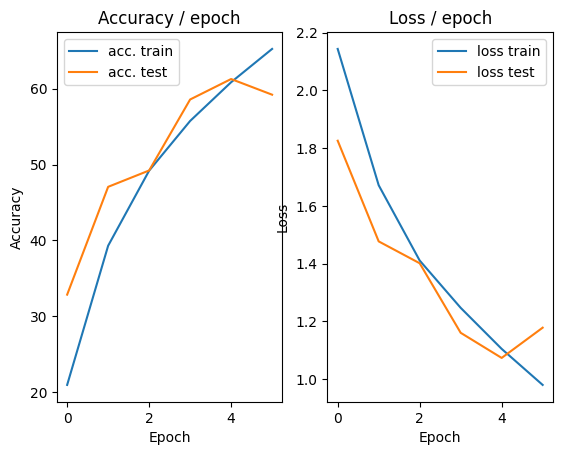

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 1.1192 (1.1192)	Prec@1  63.3 ( 63.3)	Prec@5  96.9 ( 96.9)


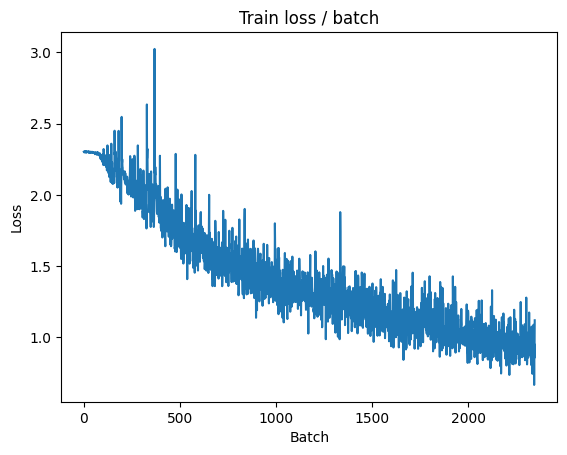

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.9344 (0.8735)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)


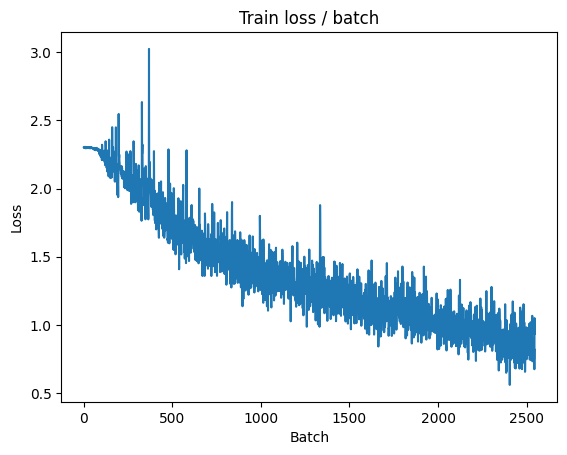


===============> Total time 5s	Avg loss 0.8743	Avg Prec@1 69.36 %	Avg Prec@5 97.63 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 0.8549 (0.8549)	Prec@1  69.5 ( 69.5)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.9351	Avg Prec@1 67.32 %	Avg Prec@5 97.18 %



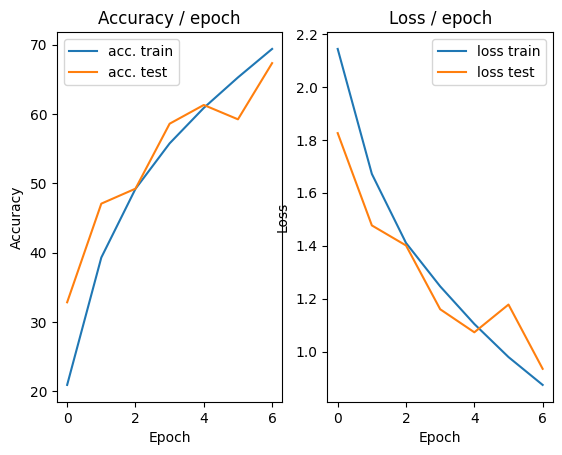

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.122s (0.122s)	Loss 0.6886 (0.6886)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)


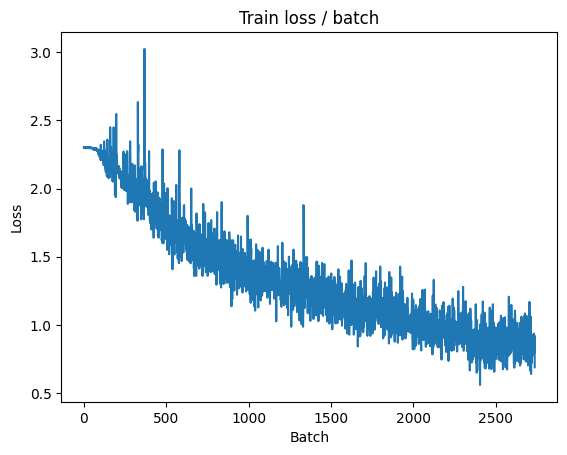

[TRAIN Batch 200/391]	Time 0.019s (0.015s)	Loss 0.8768 (0.7727)	Prec@1  68.8 ( 72.8)	Prec@5  96.9 ( 98.2)


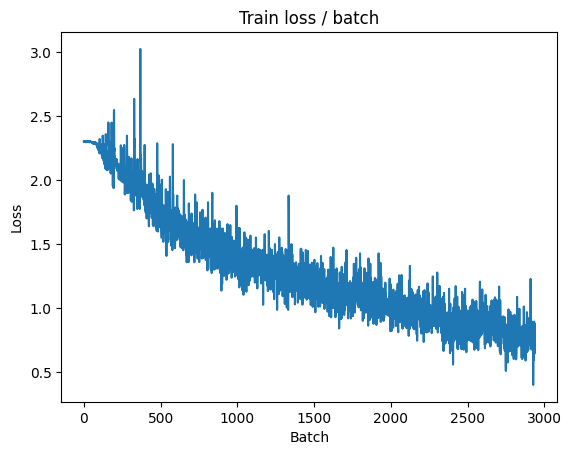


===============> Total time 5s	Avg loss 0.7733	Avg Prec@1 72.92 %	Avg Prec@5 98.18 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 0.8093 (0.8093)	Prec@1  71.1 ( 71.1)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 0.9287	Avg Prec@1 67.40 %	Avg Prec@5 97.14 %



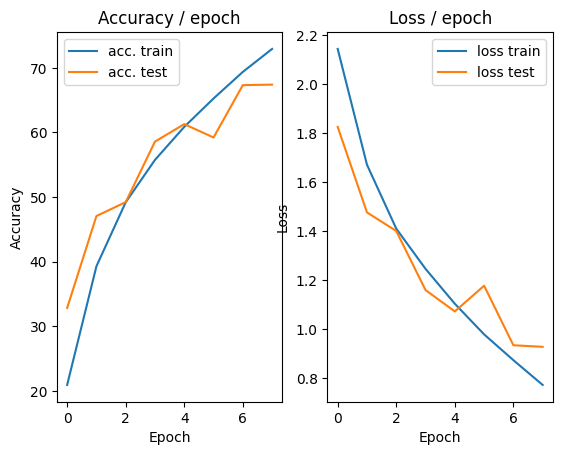

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.132s (0.132s)	Loss 0.6388 (0.6388)	Prec@1  78.9 ( 78.9)	Prec@5 100.0 (100.0)


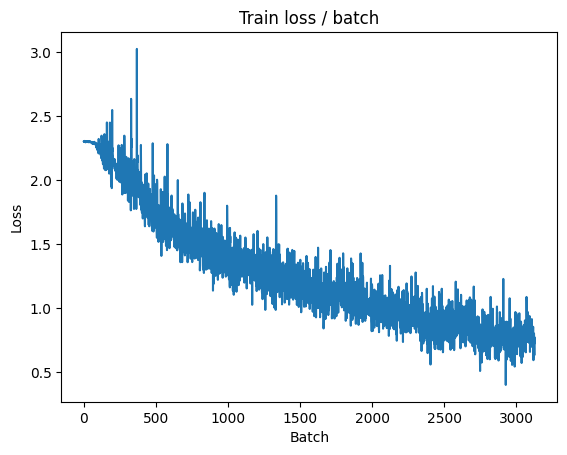

[TRAIN Batch 200/391]	Time 0.008s (0.016s)	Loss 0.6118 (0.6756)	Prec@1  77.3 ( 76.4)	Prec@5  99.2 ( 98.7)


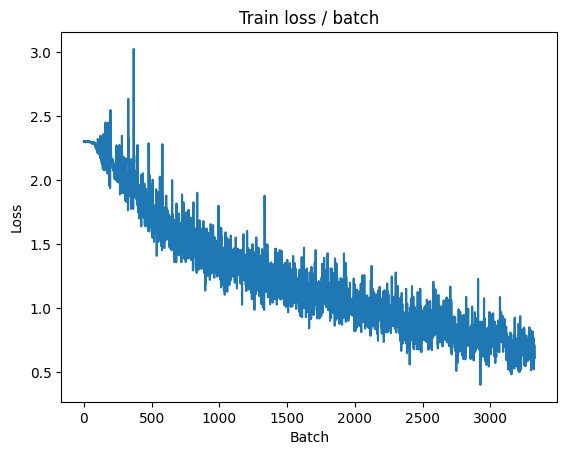


===============> Total time 5s	Avg loss 0.6772	Avg Prec@1 76.25 %	Avg Prec@5 98.72 %

[EVAL Batch 000/079]	Time 0.088s (0.088s)	Loss 0.8303 (0.8303)	Prec@1  71.1 ( 71.1)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.9199	Avg Prec@1 68.58 %	Avg Prec@5 97.36 %



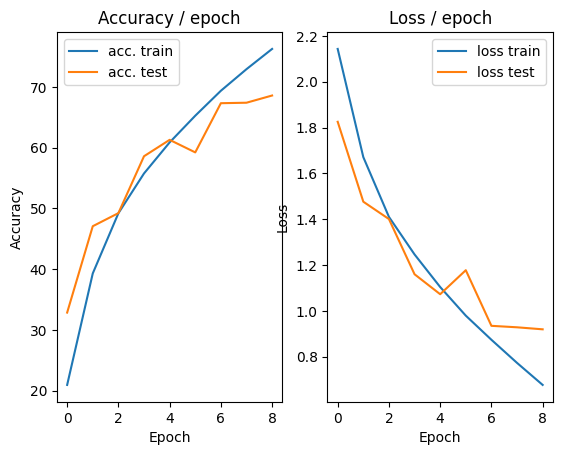

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.098s (0.098s)	Loss 0.7227 (0.7227)	Prec@1  75.8 ( 75.8)	Prec@5  97.7 ( 97.7)


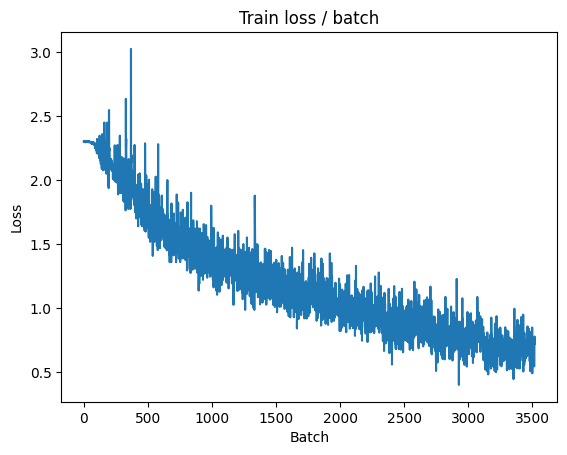

[TRAIN Batch 200/391]	Time 0.026s (0.014s)	Loss 0.4970 (0.5749)	Prec@1  78.1 ( 80.0)	Prec@5  98.4 ( 99.1)


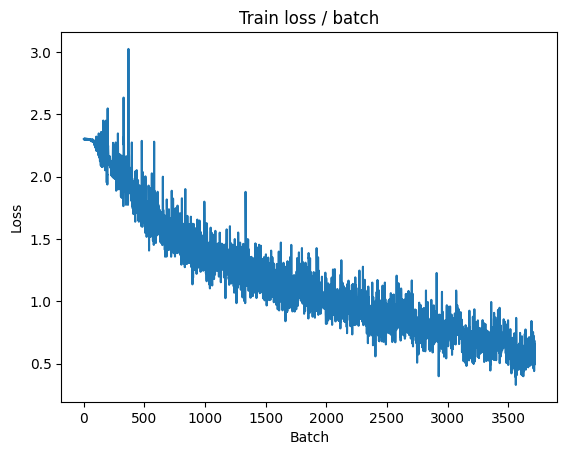


===============> Total time 5s	Avg loss 0.5841	Avg Prec@1 79.70 %	Avg Prec@5 99.05 %

[EVAL Batch 000/079]	Time 0.115s (0.115s)	Loss 0.7437 (0.7437)	Prec@1  74.2 ( 74.2)	Prec@5  99.2 ( 99.2)

===============> Total time 0s	Avg loss 0.9040	Avg Prec@1 69.39 %	Avg Prec@5 97.31 %



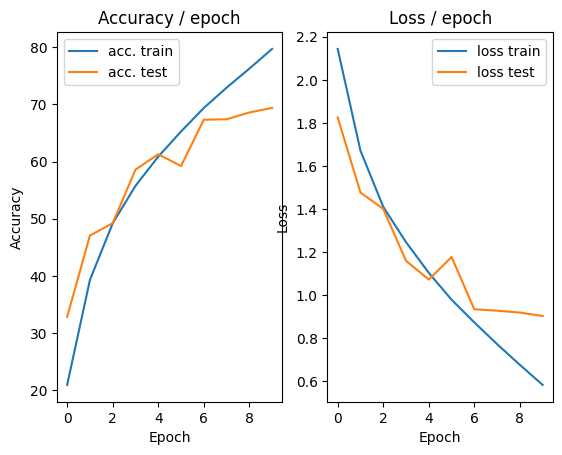

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.100s (0.100s)	Loss 0.4309 (0.4309)	Prec@1  85.2 ( 85.2)	Prec@5 100.0 (100.0)


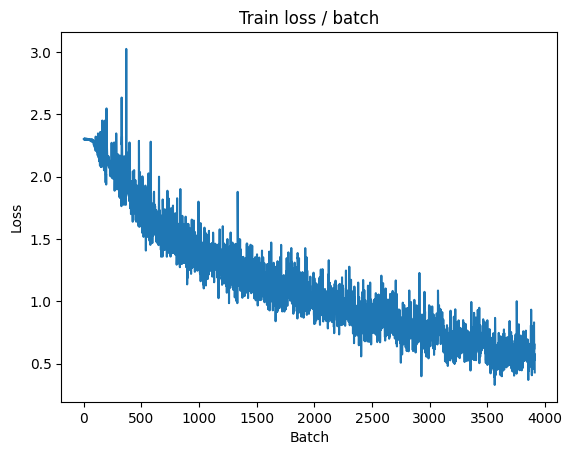

[TRAIN Batch 200/391]	Time 0.022s (0.016s)	Loss 0.5004 (0.4880)	Prec@1  78.9 ( 83.0)	Prec@5 100.0 ( 99.4)


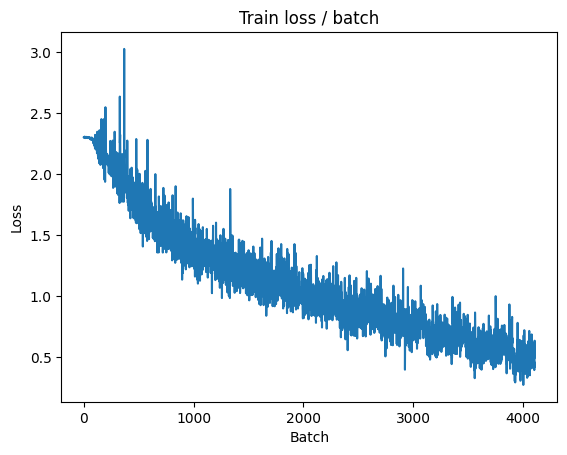


===============> Total time 5s	Avg loss 0.4970	Avg Prec@1 82.59 %	Avg Prec@5 99.39 %

[EVAL Batch 000/079]	Time 0.085s (0.085s)	Loss 0.8010 (0.8010)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 0.9728	Avg Prec@1 69.14 %	Avg Prec@5 97.23 %



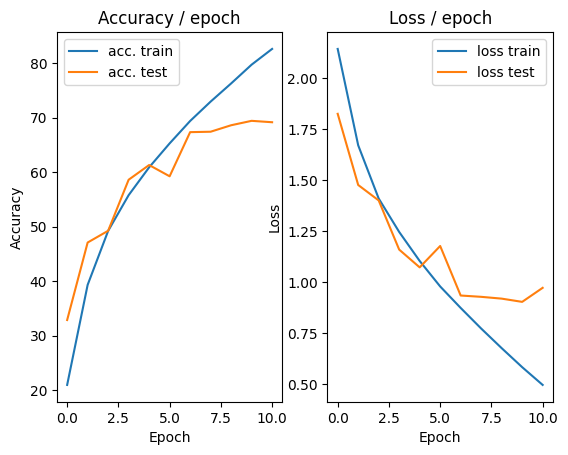

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.124s (0.124s)	Loss 0.3843 (0.3843)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


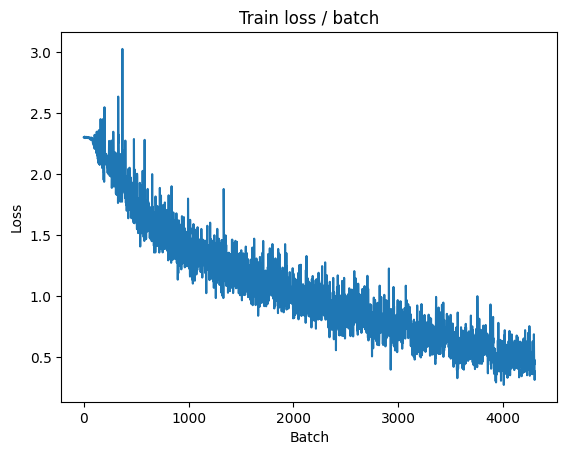

[TRAIN Batch 200/391]	Time 0.019s (0.015s)	Loss 0.4178 (0.3824)	Prec@1  85.2 ( 86.5)	Prec@5 100.0 ( 99.7)


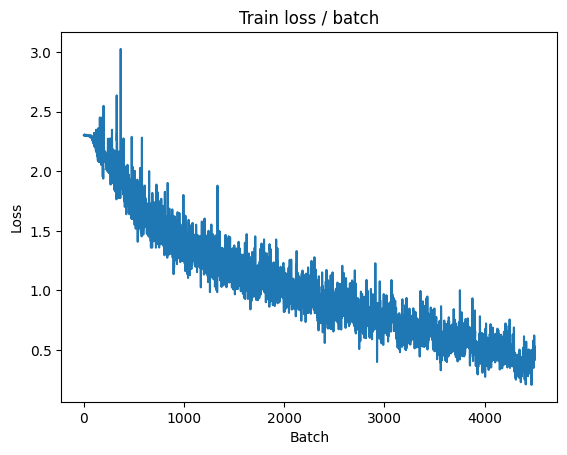


===============> Total time 5s	Avg loss 0.4016	Avg Prec@1 85.79 %	Avg Prec@5 99.62 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 0.8429 (0.8429)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9671	Avg Prec@1 70.16 %	Avg Prec@5 97.26 %



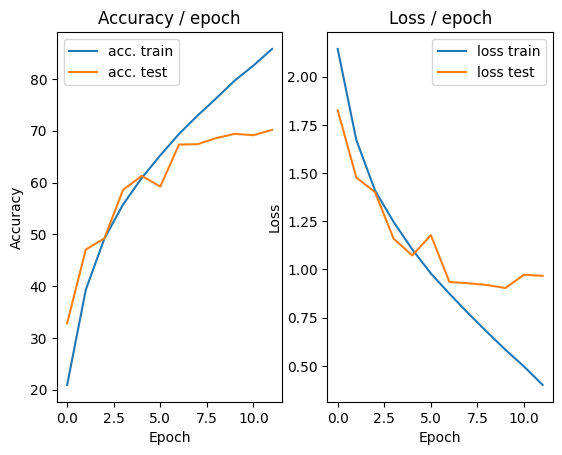

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.098s (0.098s)	Loss 0.2277 (0.2277)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


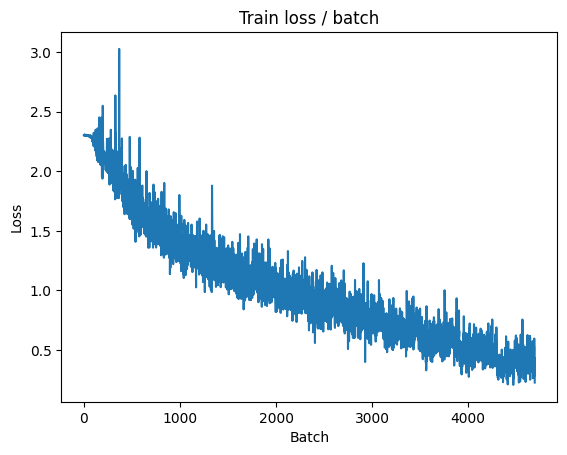

[TRAIN Batch 200/391]	Time 0.019s (0.015s)	Loss 0.2389 (0.2961)	Prec@1  91.4 ( 89.8)	Prec@5 100.0 ( 99.8)


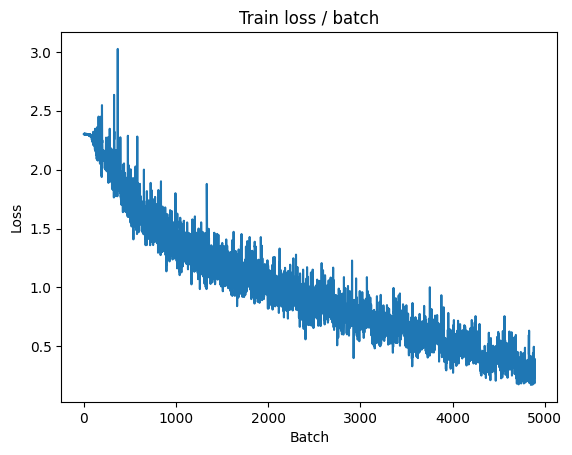


===============> Total time 5s	Avg loss 0.3150	Avg Prec@1 89.01 %	Avg Prec@5 99.79 %

[EVAL Batch 000/079]	Time 0.090s (0.090s)	Loss 0.8650 (0.8650)	Prec@1  71.9 ( 71.9)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.0989	Avg Prec@1 69.05 %	Avg Prec@5 97.12 %



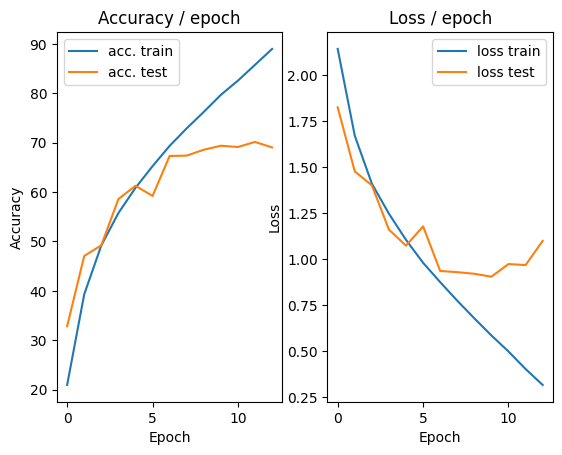

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.100s (0.100s)	Loss 0.3024 (0.3024)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)


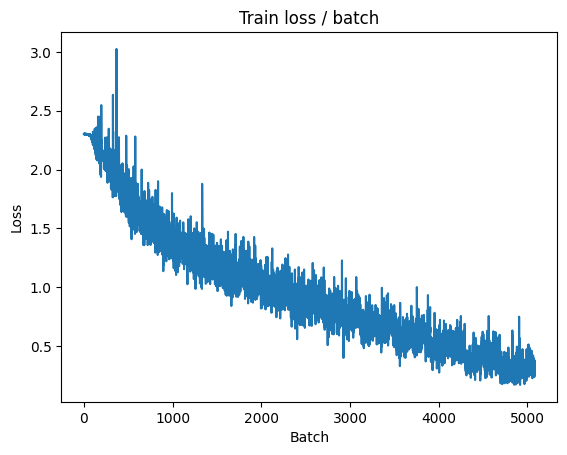

[TRAIN Batch 200/391]	Time 0.006s (0.016s)	Loss 0.1181 (0.2207)	Prec@1  96.9 ( 92.6)	Prec@5 100.0 ( 99.9)


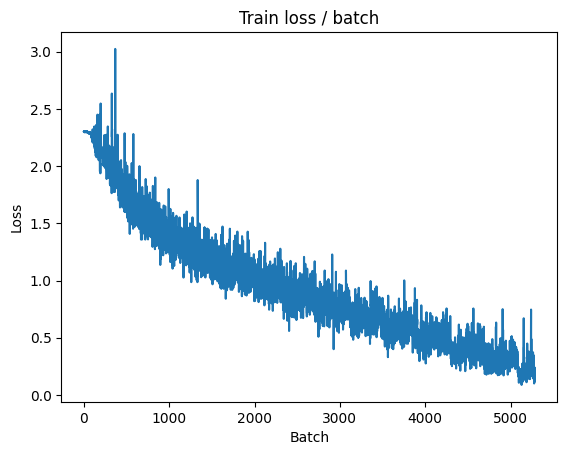


===============> Total time 5s	Avg loss 0.2398	Avg Prec@1 91.84 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 1.5596 (1.5596)	Prec@1  61.7 ( 61.7)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.4980	Avg Prec@1 63.04 %	Avg Prec@5 96.18 %



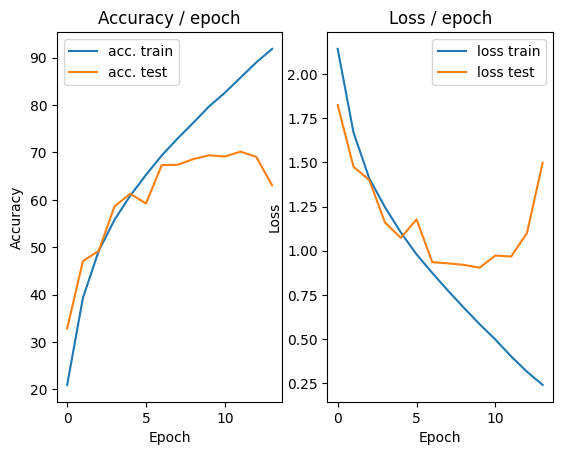

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.124s (0.124s)	Loss 0.5724 (0.5724)	Prec@1  78.1 ( 78.1)	Prec@5 100.0 (100.0)


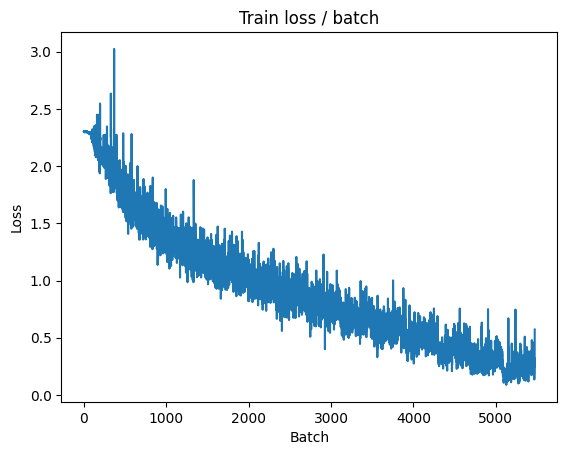

[TRAIN Batch 200/391]	Time 0.006s (0.016s)	Loss 0.1070 (0.1526)	Prec@1  96.1 ( 95.0)	Prec@5 100.0 (100.0)


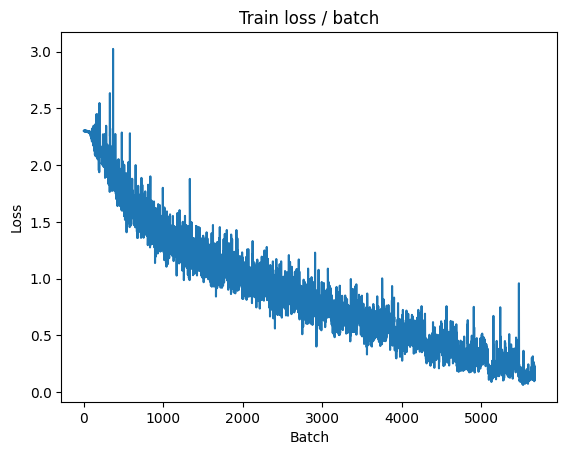


===============> Total time 6s	Avg loss 0.1739	Avg Prec@1 94.19 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.127s (0.127s)	Loss 1.1275 (1.1275)	Prec@1  69.5 ( 69.5)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 1.2351	Avg Prec@1 69.31 %	Avg Prec@5 97.10 %



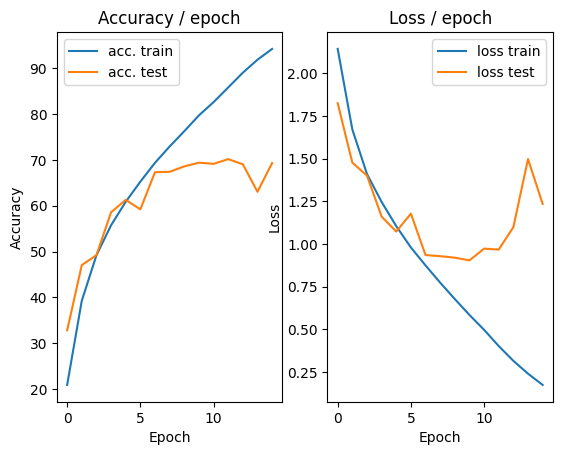

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.121s (0.121s)	Loss 0.1085 (0.1085)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


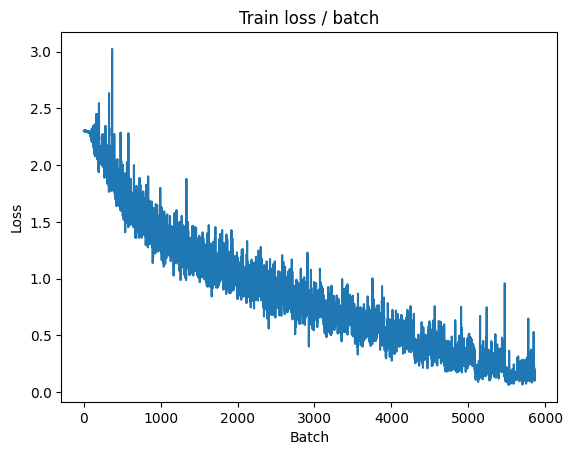

[TRAIN Batch 200/391]	Time 0.018s (0.014s)	Loss 0.0724 (0.0928)	Prec@1  99.2 ( 97.1)	Prec@5 100.0 (100.0)


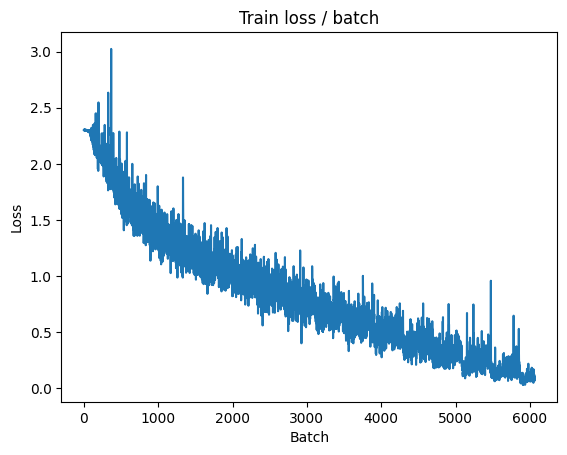


===============> Total time 5s	Avg loss 0.1186	Avg Prec@1 96.26 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.120s (0.120s)	Loss 1.0854 (1.0854)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.3462	Avg Prec@1 69.52 %	Avg Prec@5 97.00 %



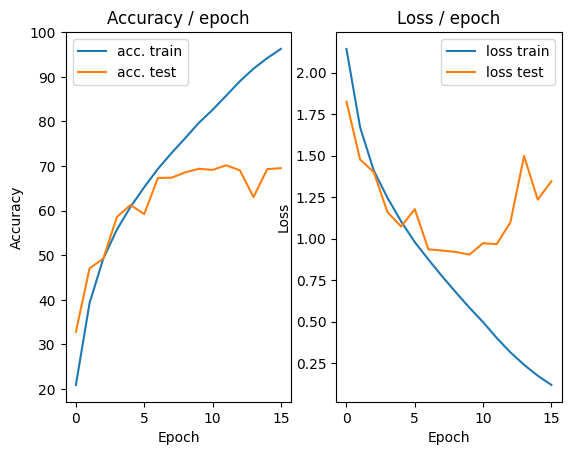

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.102s (0.102s)	Loss 0.1702 (0.1702)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


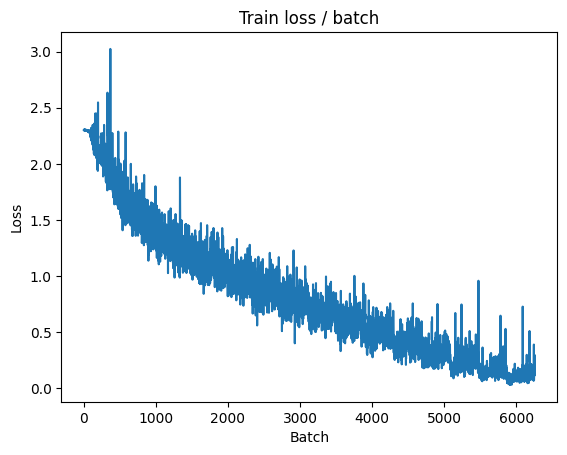

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.1029 (0.0661)	Prec@1  96.1 ( 98.1)	Prec@5 100.0 (100.0)


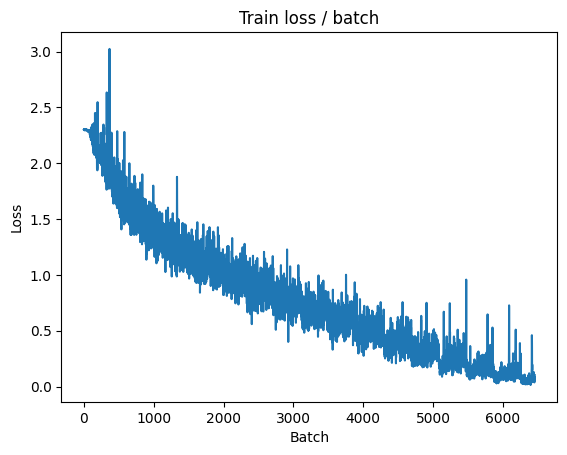


===============> Total time 5s	Avg loss 0.0804	Avg Prec@1 97.60 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.2407 (1.2407)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.5172	Avg Prec@1 69.79 %	Avg Prec@5 96.81 %



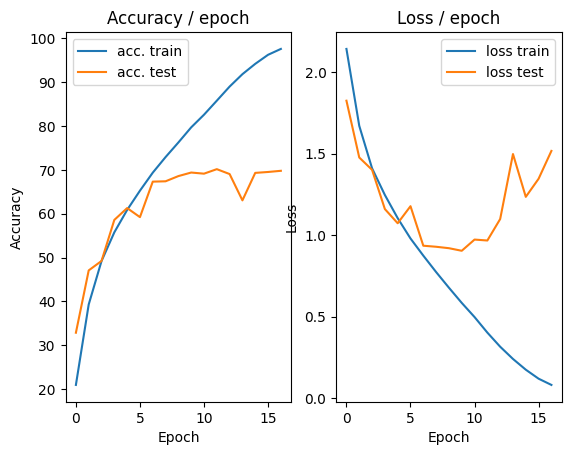

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.102s (0.102s)	Loss 0.0956 (0.0956)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


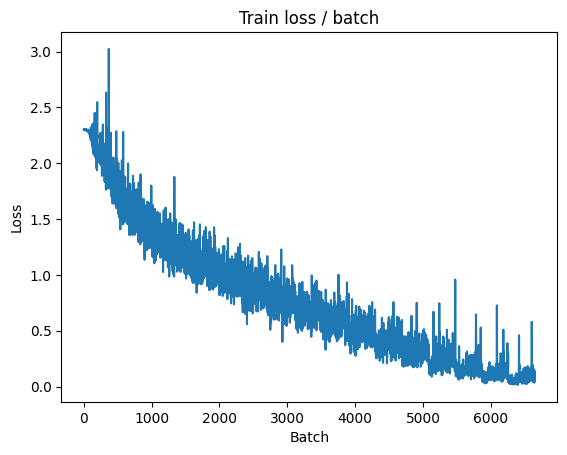

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.0123 (0.0336)	Prec@1 100.0 ( 99.2)	Prec@5 100.0 (100.0)


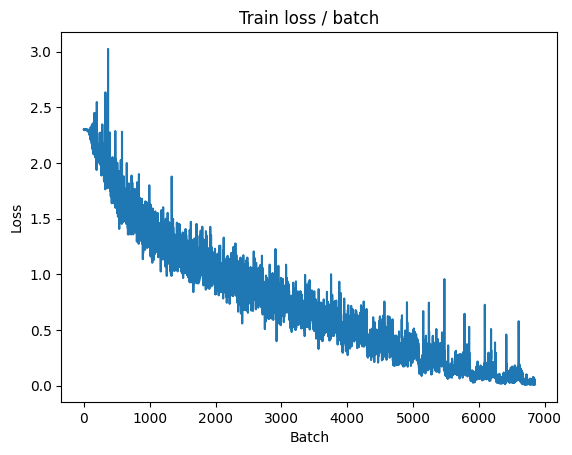


===============> Total time 5s	Avg loss 0.0539	Avg Prec@1 98.38 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.088s (0.088s)	Loss 1.3766 (1.3766)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.5658	Avg Prec@1 70.42 %	Avg Prec@5 97.16 %



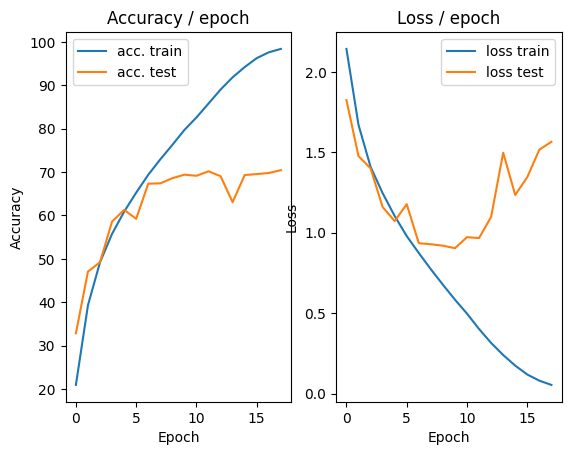

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.108s (0.108s)	Loss 0.0272 (0.0272)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


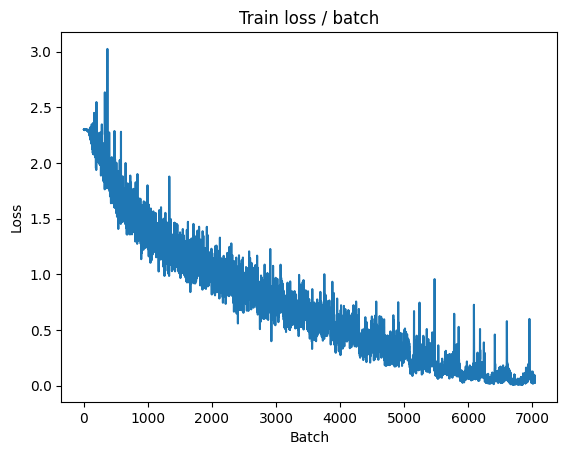

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.0792 (0.0319)	Prec@1  96.9 ( 99.2)	Prec@5 100.0 (100.0)


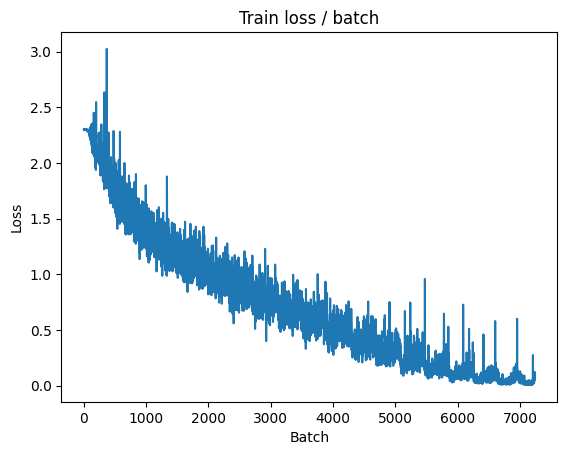


===============> Total time 5s	Avg loss 0.0745	Avg Prec@1 98.05 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.093s (0.093s)	Loss 1.3170 (1.3170)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 0s	Avg loss 1.4917	Avg Prec@1 71.21 %	Avg Prec@5 97.23 %



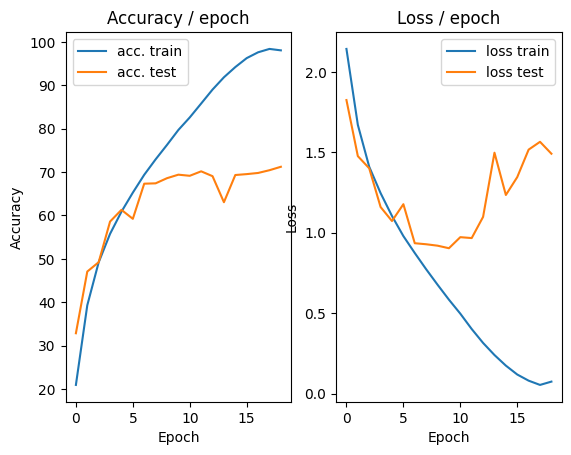

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.101s (0.101s)	Loss 0.0264 (0.0264)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


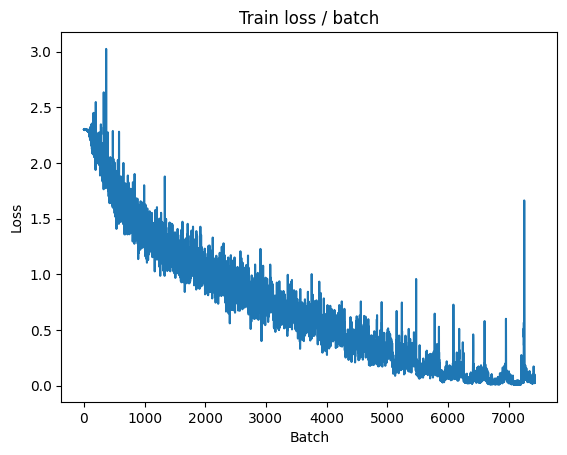

[TRAIN Batch 200/391]	Time 0.006s (0.017s)	Loss 0.0096 (0.0179)	Prec@1 100.0 ( 99.6)	Prec@5 100.0 (100.0)


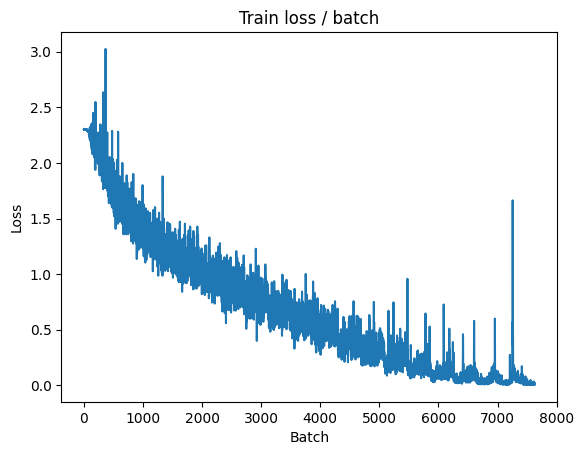


===============> Total time 5s	Avg loss 0.0156	Avg Prec@1 99.66 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.088s (0.088s)	Loss 1.4039 (1.4039)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.6911	Avg Prec@1 72.21 %	Avg Prec@5 97.30 %



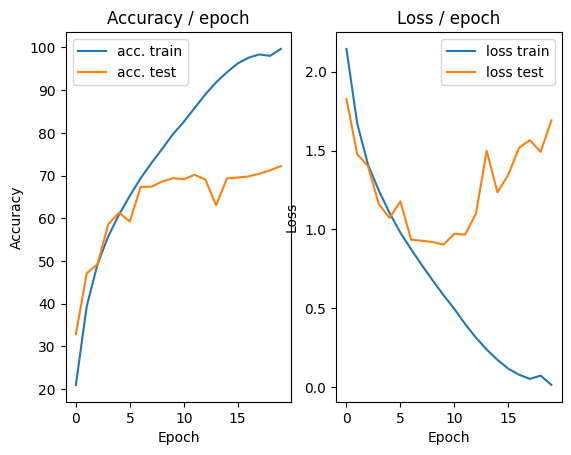

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.109s (0.109s)	Loss 0.0152 (0.0152)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


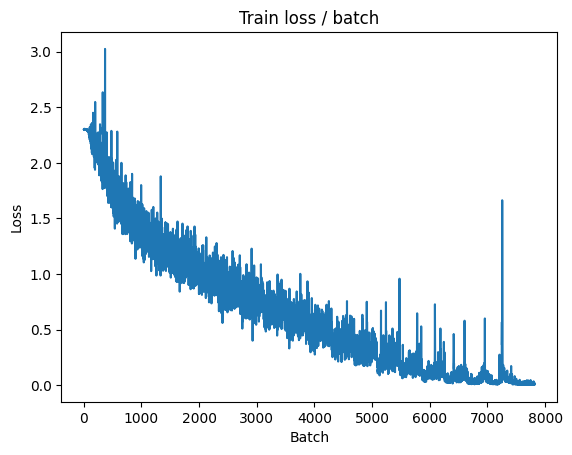

[TRAIN Batch 200/391]	Time 0.011s (0.015s)	Loss 0.0021 (0.0036)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


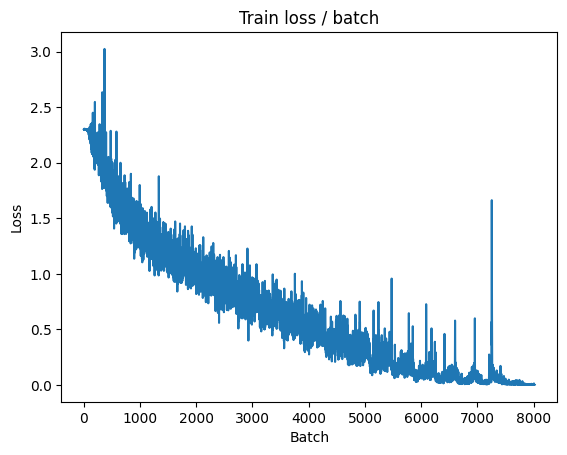


===============> Total time 5s	Avg loss 0.0031	Avg Prec@1 99.98 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.087s (0.087s)	Loss 1.4773 (1.4773)	Prec@1  75.8 ( 75.8)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.8071	Avg Prec@1 72.65 %	Avg Prec@5 97.45 %



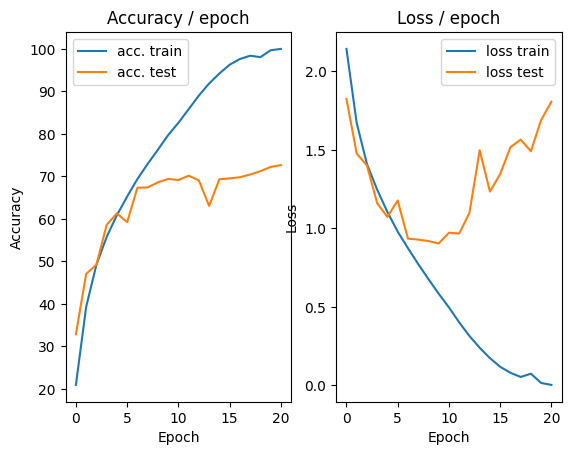

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.100s (0.100s)	Loss 0.0018 (0.0018)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


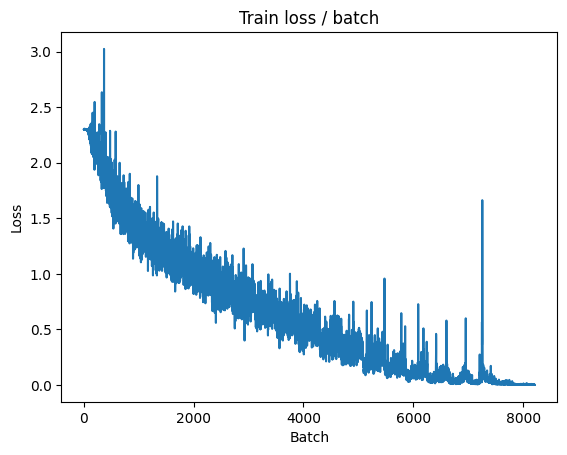

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.0013 (0.0011)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


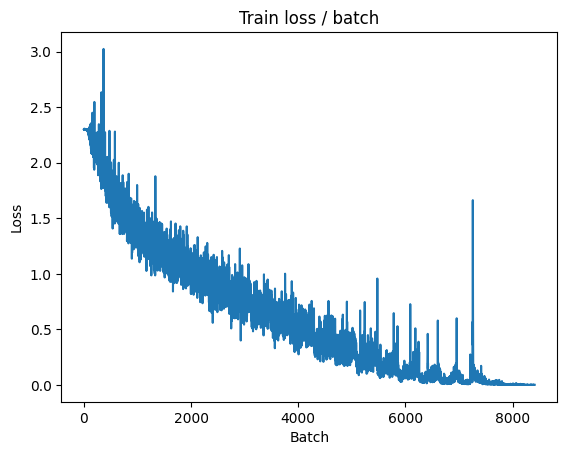


===============> Total time 5s	Avg loss 0.0014	Avg Prec@1 99.98 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.090s (0.090s)	Loss 1.5091 (1.5091)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.8709	Avg Prec@1 72.71 %	Avg Prec@5 97.50 %



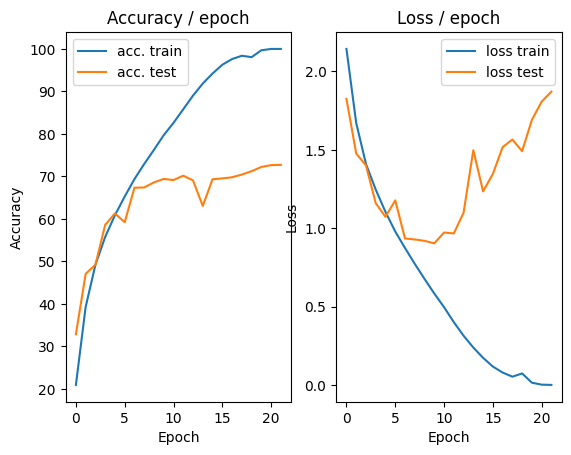

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.107s (0.107s)	Loss 0.0005 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


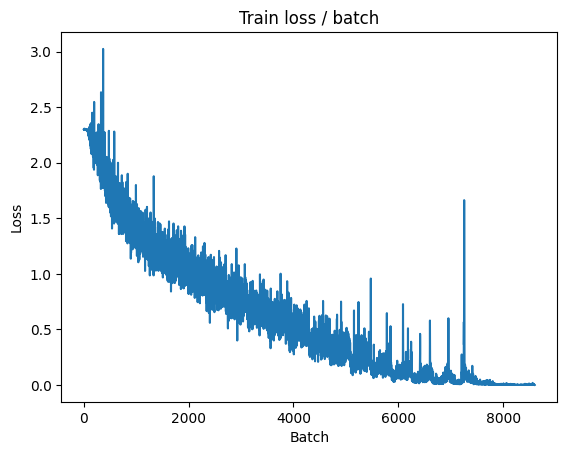

[TRAIN Batch 200/391]	Time 0.007s (0.015s)	Loss 0.0007 (0.0010)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


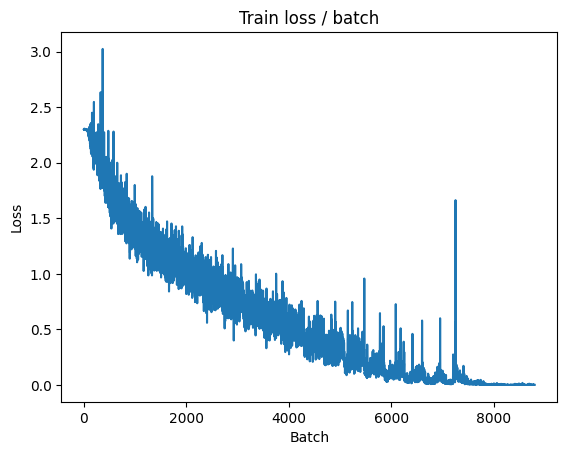


===============> Total time 5s	Avg loss 0.0009	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.092s (0.092s)	Loss 1.5156 (1.5156)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.9298	Avg Prec@1 72.69 %	Avg Prec@5 97.51 %



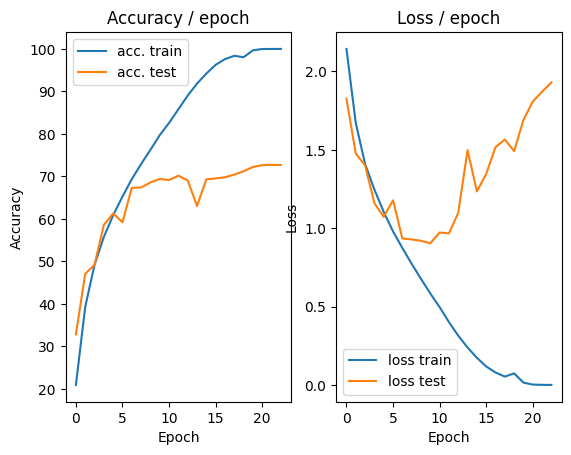

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.103s (0.103s)	Loss 0.0007 (0.0007)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


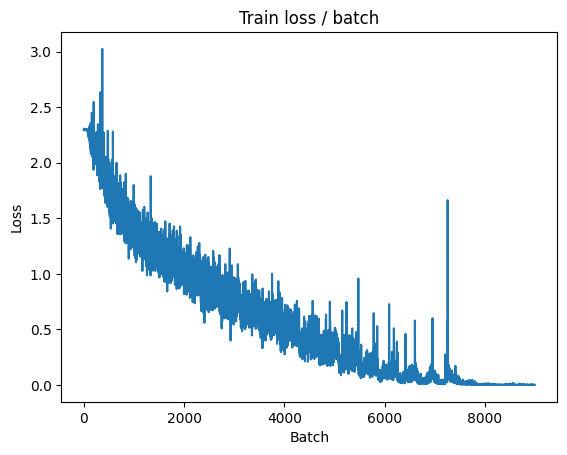

[TRAIN Batch 200/391]	Time 0.015s (0.015s)	Loss 0.0006 (0.0006)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


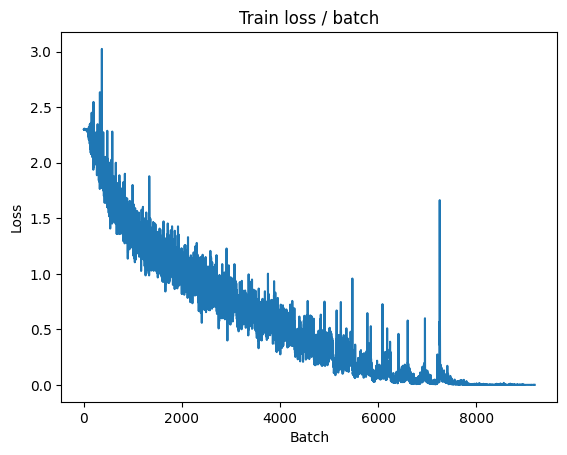


===============> Total time 6s	Avg loss 0.0006	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.089s (0.089s)	Loss 1.5674 (1.5674)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)

===============> Total time 0s	Avg loss 1.9743	Avg Prec@1 72.81 %	Avg Prec@5 97.51 %



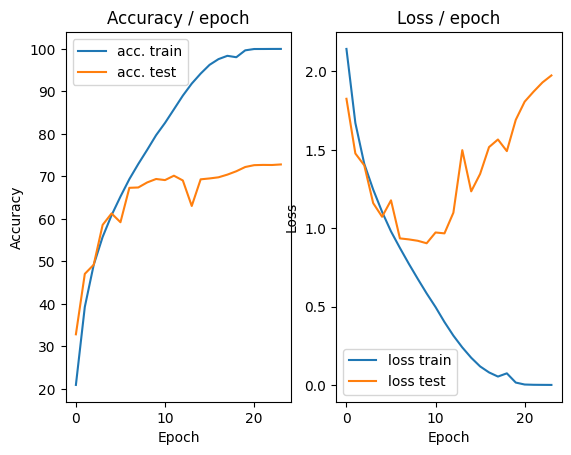

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.102s (0.102s)	Loss 0.0006 (0.0006)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


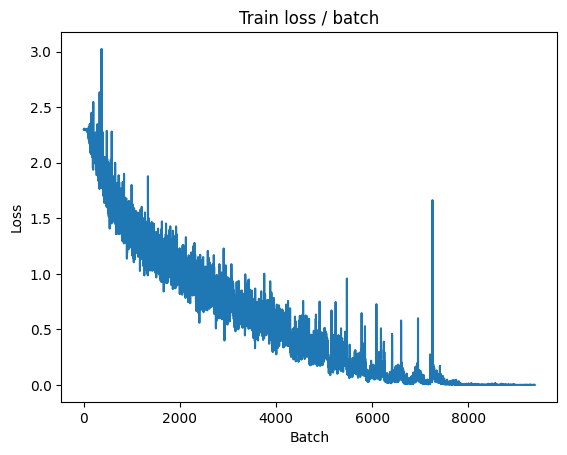

[TRAIN Batch 200/391]	Time 0.019s (0.015s)	Loss 0.0005 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


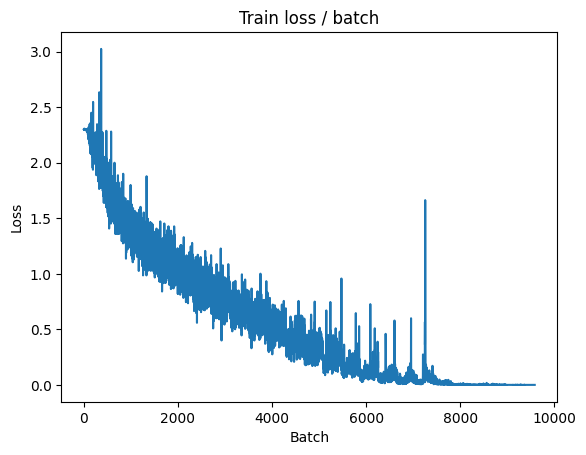


===============> Total time 5s	Avg loss 0.0005	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 1.5963 (1.5963)	Prec@1  73.4 ( 73.4)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.0063	Avg Prec@1 72.85 %	Avg Prec@5 97.53 %



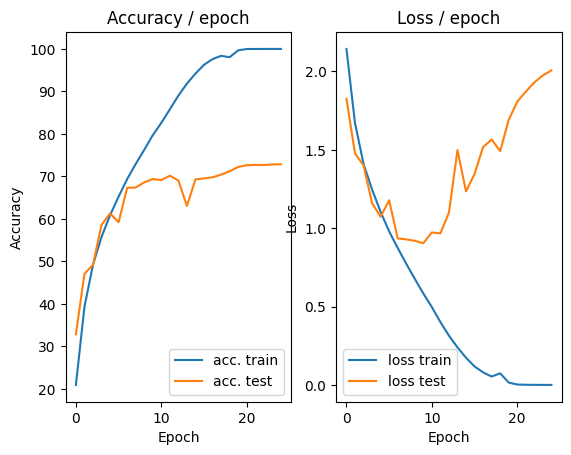

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.103s (0.103s)	Loss 0.0006 (0.0006)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


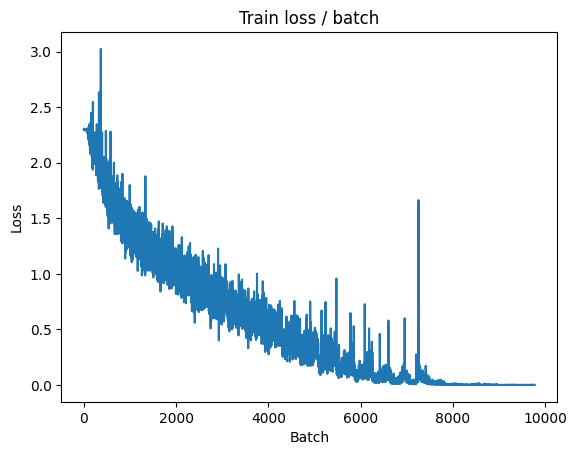

[TRAIN Batch 200/391]	Time 0.019s (0.015s)	Loss 0.0003 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


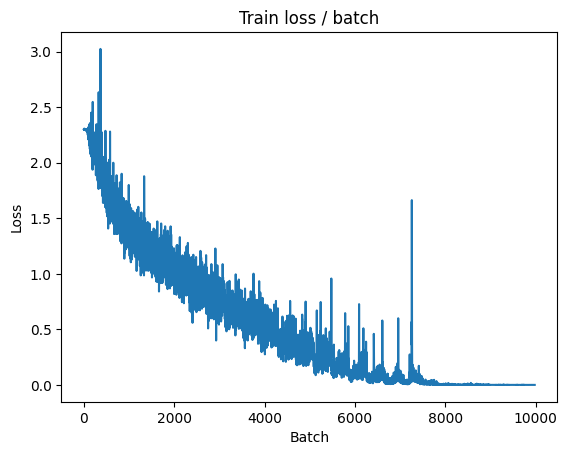


===============> Total time 5s	Avg loss 0.0004	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.110s (0.110s)	Loss 1.6248 (1.6248)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.0376	Avg Prec@1 72.88 %	Avg Prec@5 97.50 %



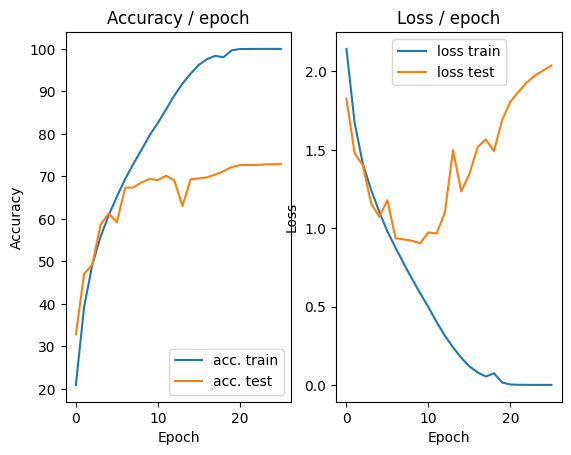

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.129s (0.129s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


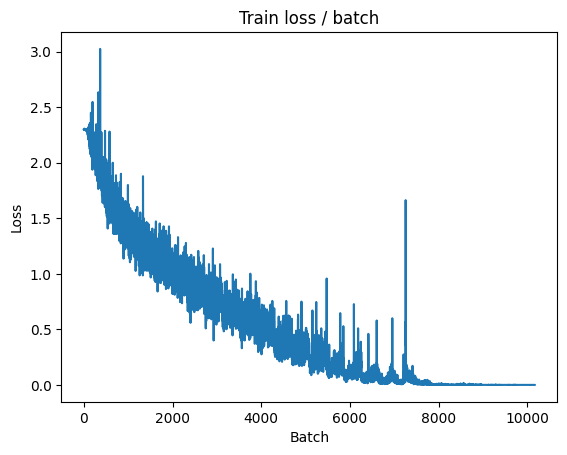

[TRAIN Batch 200/391]	Time 0.005s (0.015s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


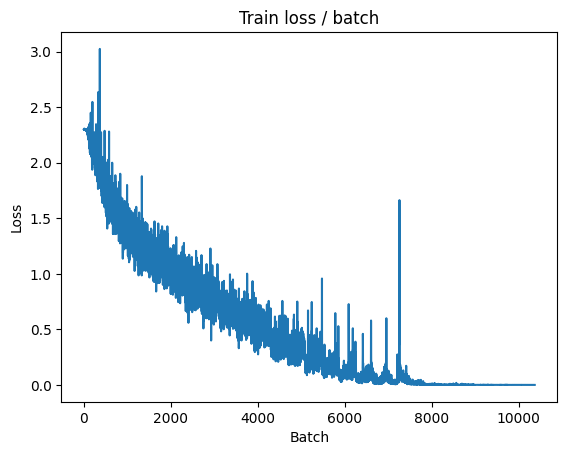


===============> Total time 5s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.087s (0.087s)	Loss 1.6451 (1.6451)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.0673	Avg Prec@1 72.86 %	Avg Prec@5 97.51 %



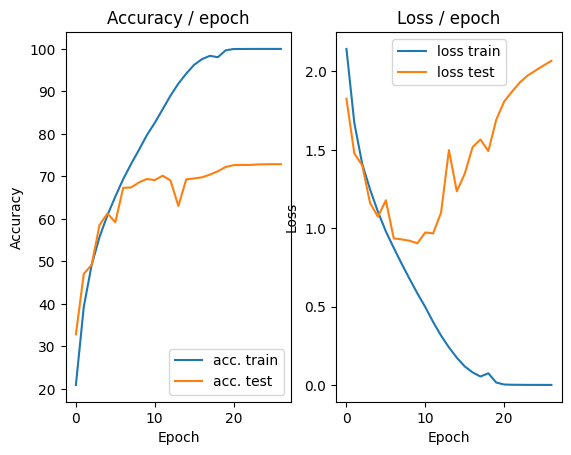

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.104s (0.104s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


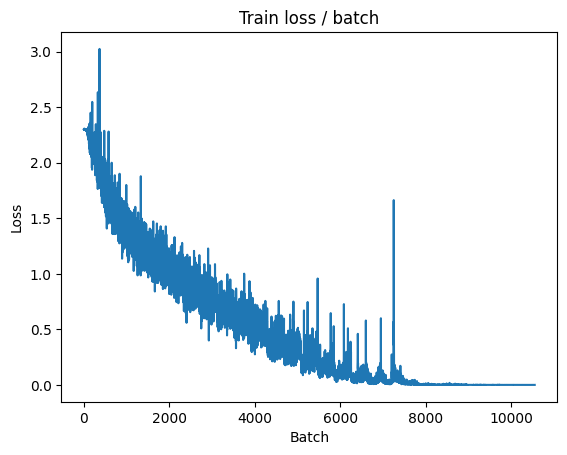

[TRAIN Batch 200/391]	Time 0.006s (0.016s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


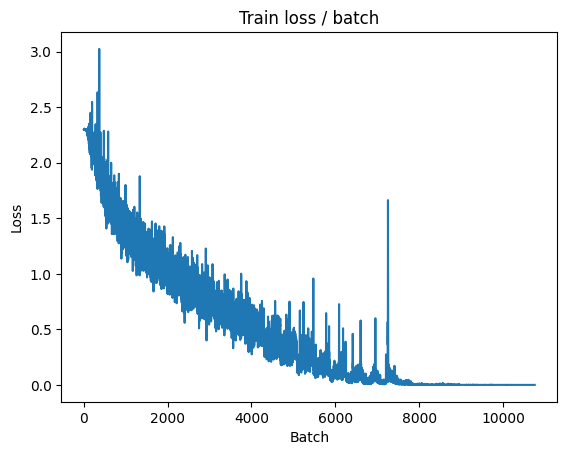


===============> Total time 5s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.090s (0.090s)	Loss 1.6611 (1.6611)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.0902	Avg Prec@1 72.77 %	Avg Prec@5 97.50 %



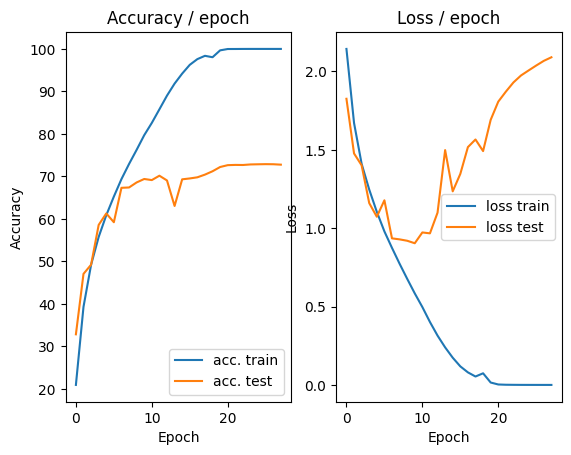

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.128s (0.128s)	Loss 0.0005 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


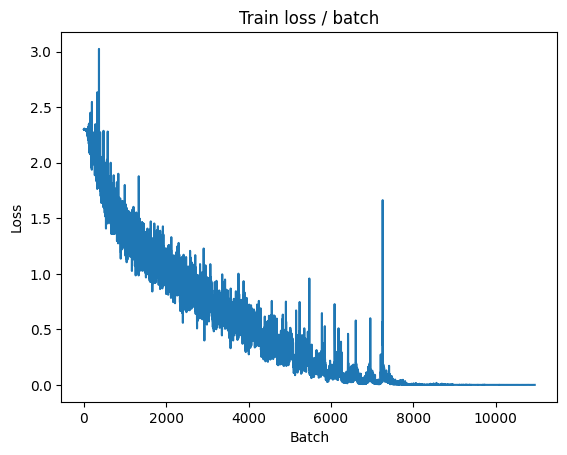

[TRAIN Batch 200/391]	Time 0.009s (0.015s)	Loss 0.0002 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


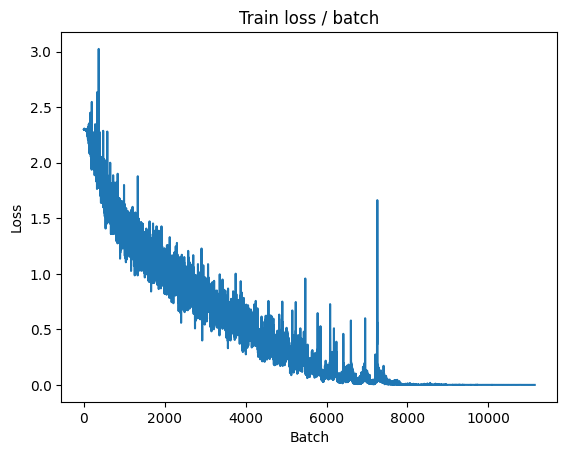


===============> Total time 5s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.092s (0.092s)	Loss 1.6811 (1.6811)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.1094	Avg Prec@1 72.86 %	Avg Prec@5 97.50 %



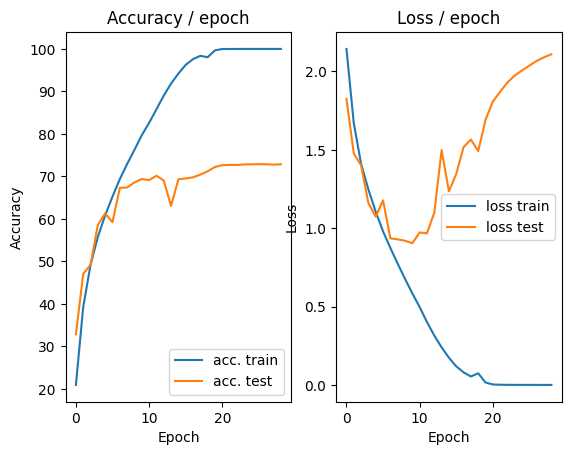

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.104s (0.104s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


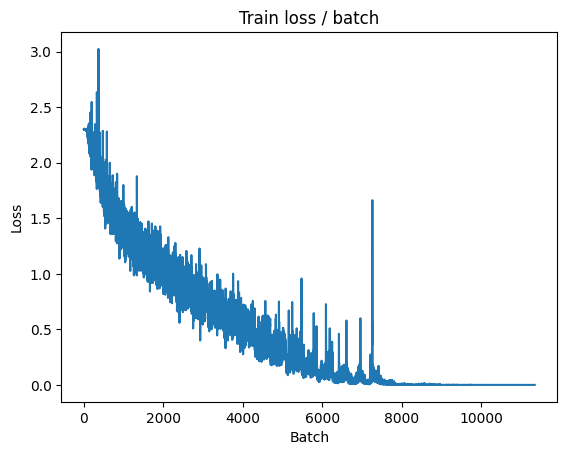

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.0003 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


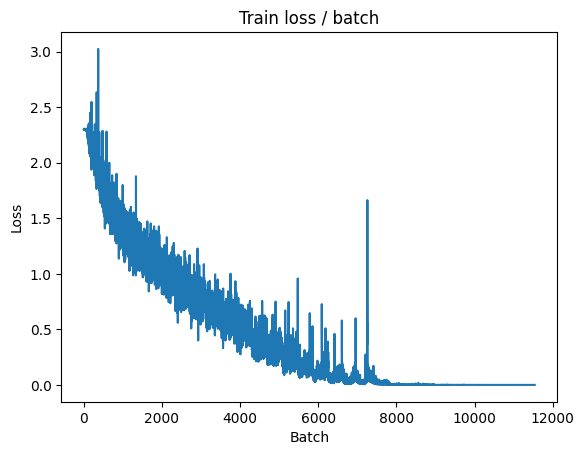


===============> Total time 5s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.7030 (1.7030)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.1315	Avg Prec@1 72.78 %	Avg Prec@5 97.54 %



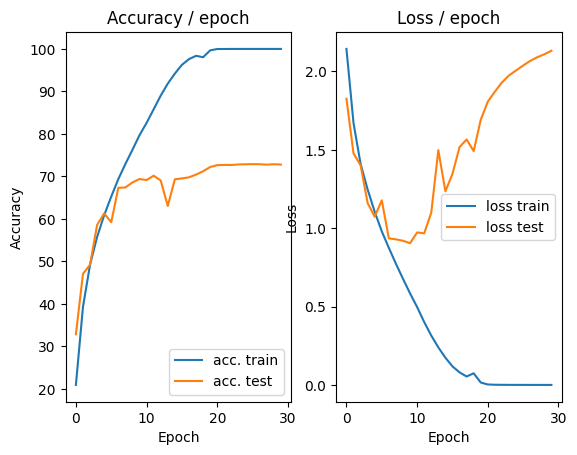

=== EPOCH 31 =====

[TRAIN Batch 000/391]	Time 0.110s (0.110s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


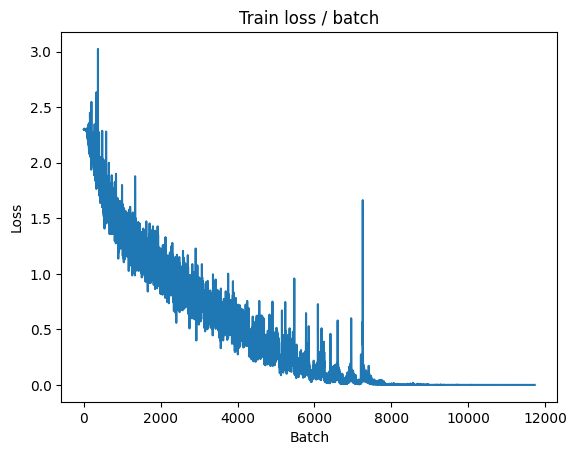

[TRAIN Batch 200/391]	Time 0.024s (0.015s)	Loss 0.0003 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


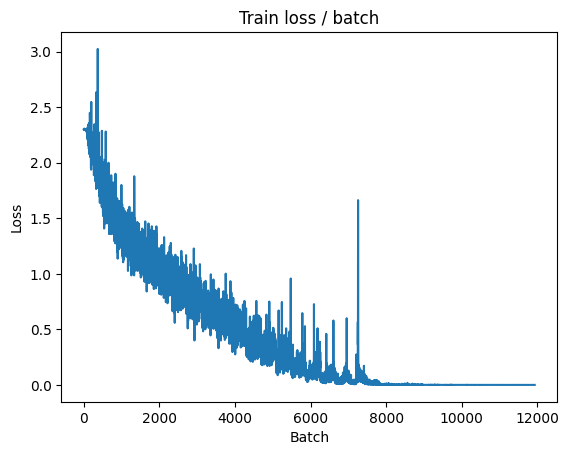


===============> Total time 5s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.089s (0.089s)	Loss 1.7203 (1.7203)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 0s	Avg loss 2.1474	Avg Prec@1 72.86 %	Avg Prec@5 97.50 %



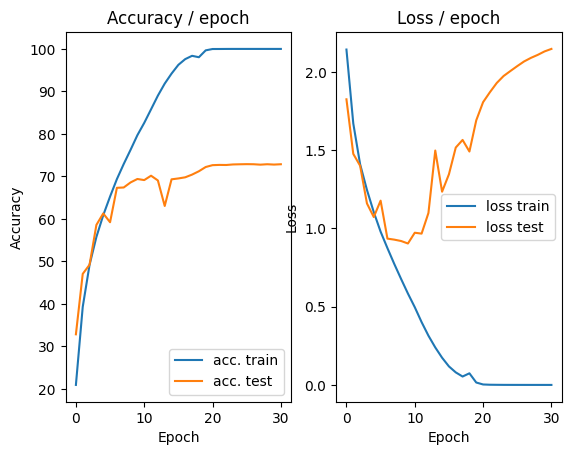

=== EPOCH 32 =====

[TRAIN Batch 000/391]	Time 0.104s (0.104s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


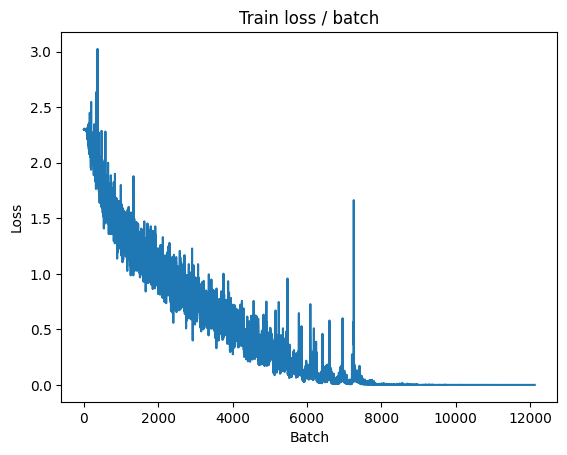

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


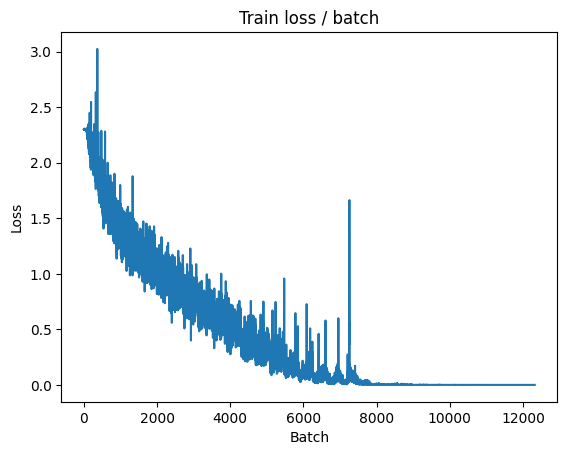


===============> Total time 5s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.109s (0.109s)	Loss 1.7352 (1.7352)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.1605	Avg Prec@1 72.84 %	Avg Prec@5 97.48 %



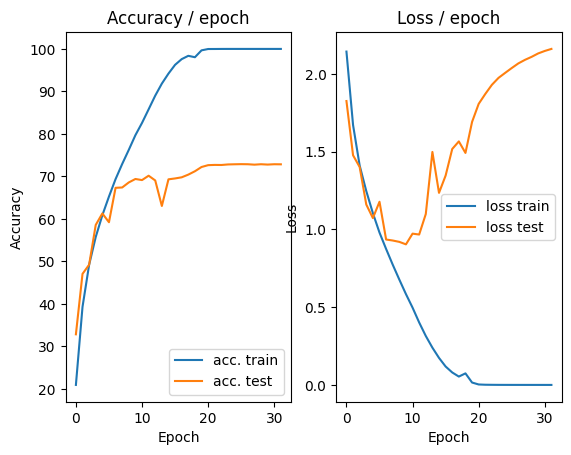

=== EPOCH 33 =====

[TRAIN Batch 000/391]	Time 0.130s (0.130s)	Loss 0.0001 (0.0001)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


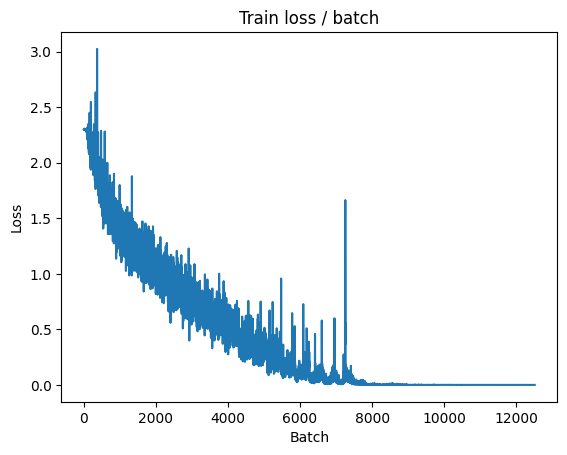

[TRAIN Batch 200/391]	Time 0.006s (0.017s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


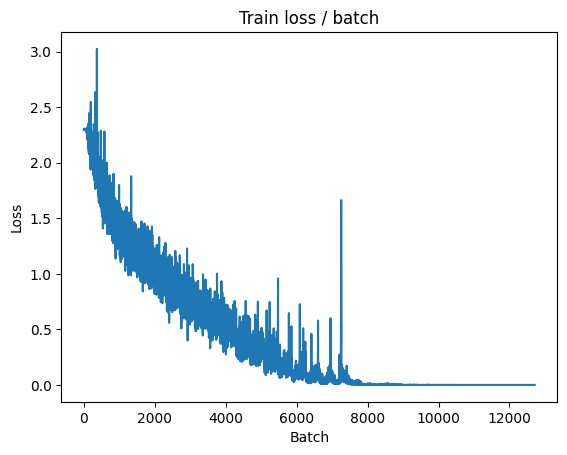


===============> Total time 6s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.117s (0.117s)	Loss 1.7468 (1.7468)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.1780	Avg Prec@1 72.90 %	Avg Prec@5 97.52 %



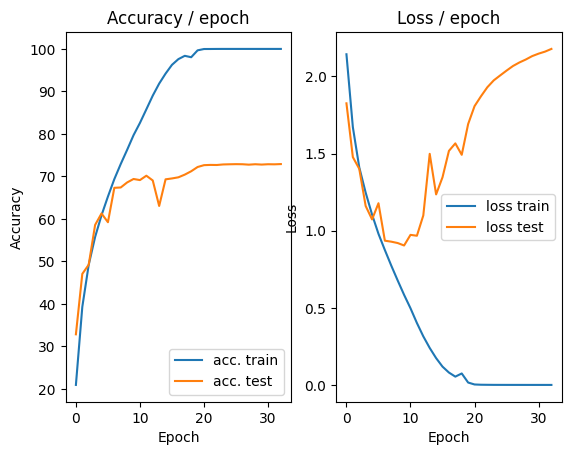

=== EPOCH 34 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


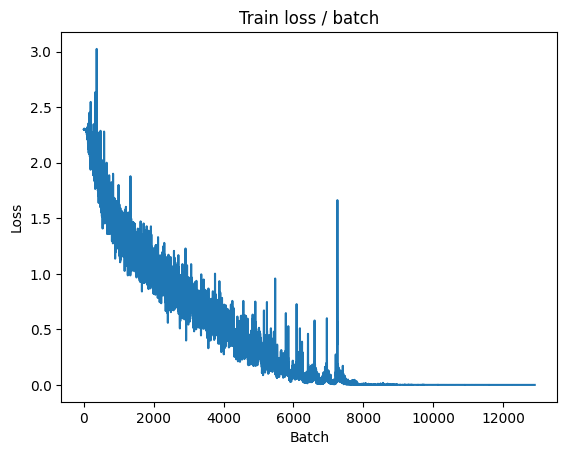

[TRAIN Batch 200/391]	Time 0.007s (0.015s)	Loss 0.0001 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


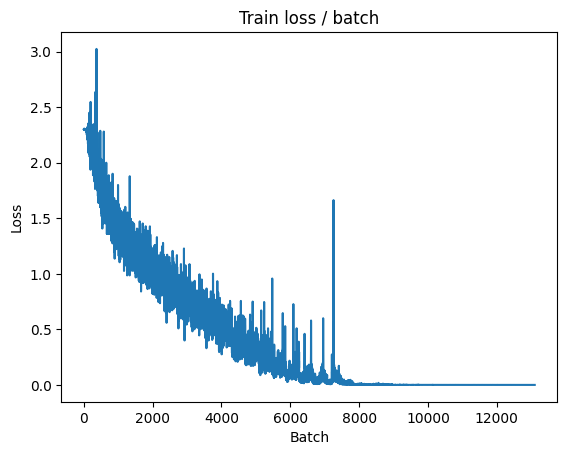


===============> Total time 5s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 1.7602 (1.7602)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.1938	Avg Prec@1 72.87 %	Avg Prec@5 97.52 %



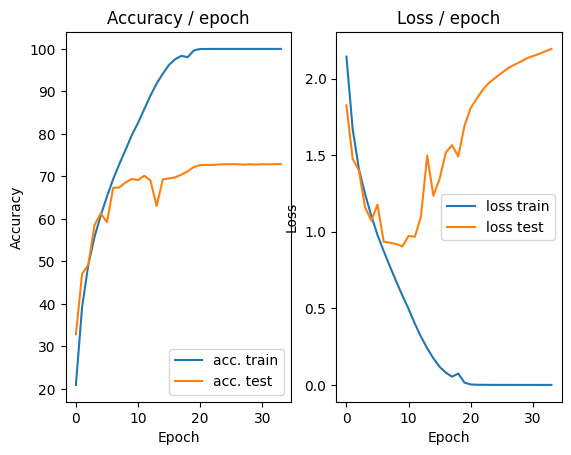

=== EPOCH 35 =====

[TRAIN Batch 000/391]	Time 0.135s (0.135s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


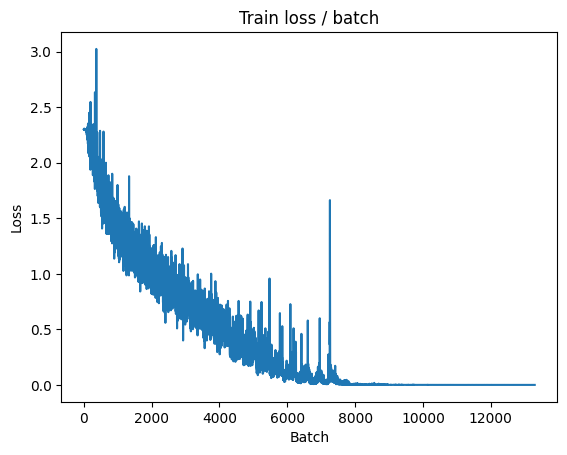

[TRAIN Batch 200/391]	Time 0.020s (0.015s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


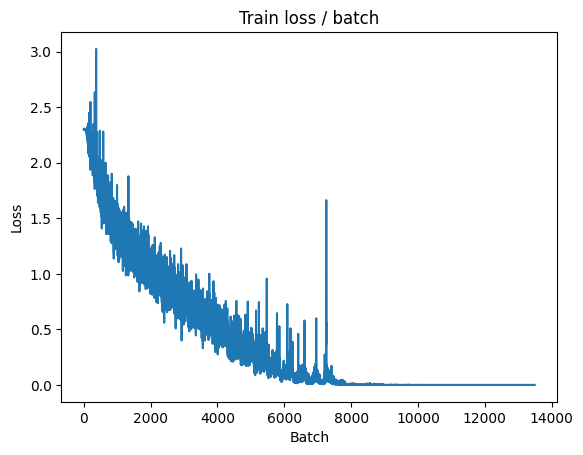


===============> Total time 5s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.089s (0.089s)	Loss 1.7725 (1.7725)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.2056	Avg Prec@1 72.89 %	Avg Prec@5 97.50 %



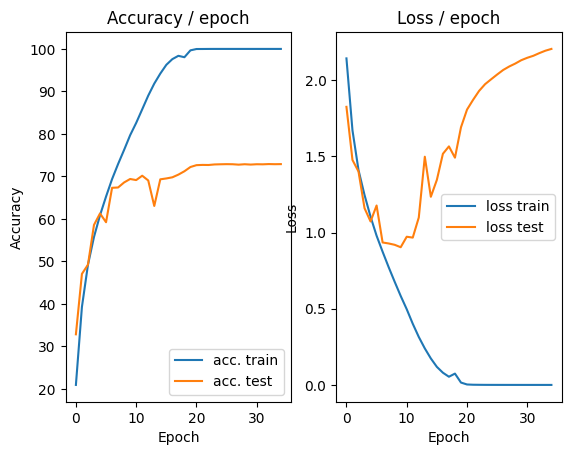

=== EPOCH 36 =====

[TRAIN Batch 000/391]	Time 0.130s (0.130s)	Loss 0.0001 (0.0001)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


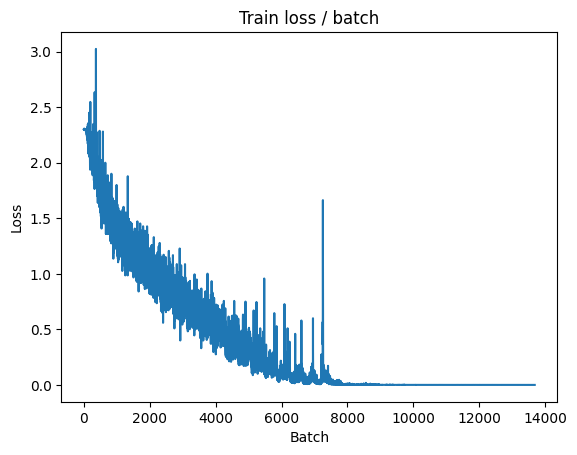

[TRAIN Batch 200/391]	Time 0.016s (0.015s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


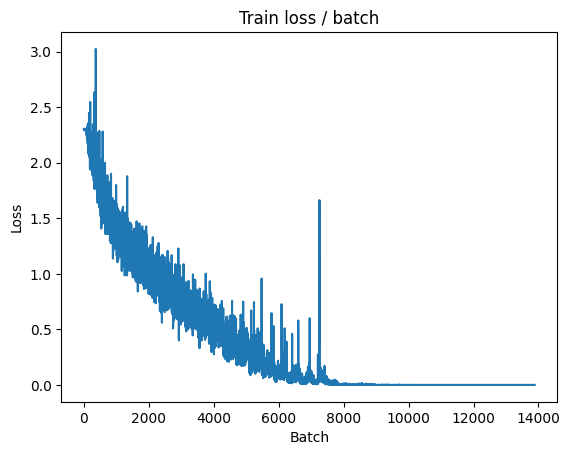


===============> Total time 5s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.087s (0.087s)	Loss 1.7825 (1.7825)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.2193	Avg Prec@1 72.88 %	Avg Prec@5 97.52 %



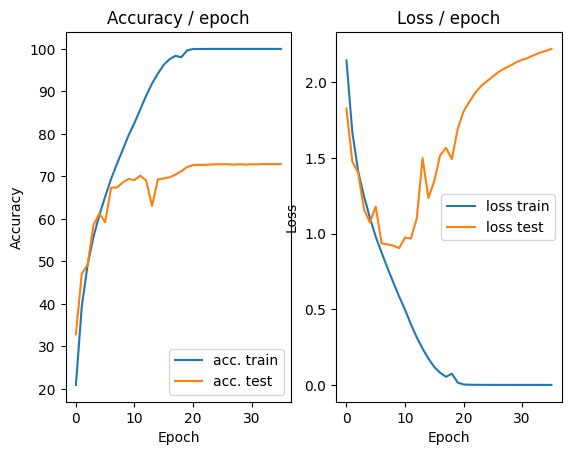

=== EPOCH 37 =====

[TRAIN Batch 000/391]	Time 0.134s (0.134s)	Loss 0.0001 (0.0001)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


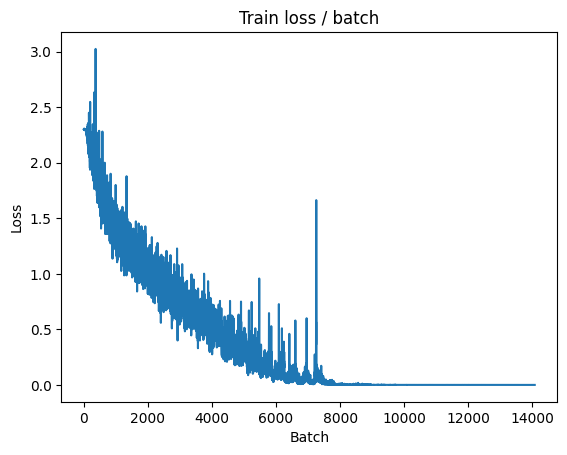

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


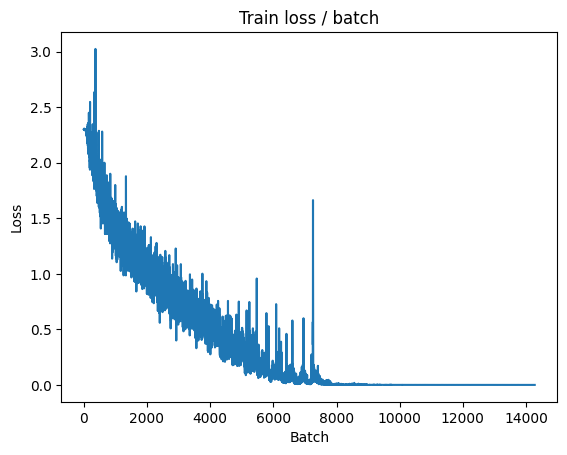


===============> Total time 5s	Avg loss 0.0002	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.111s (0.111s)	Loss 1.7941 (1.7941)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.2278	Avg Prec@1 72.91 %	Avg Prec@5 97.51 %



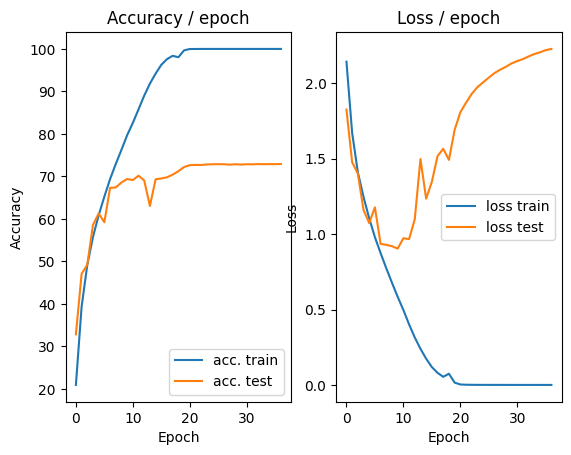

=== EPOCH 38 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


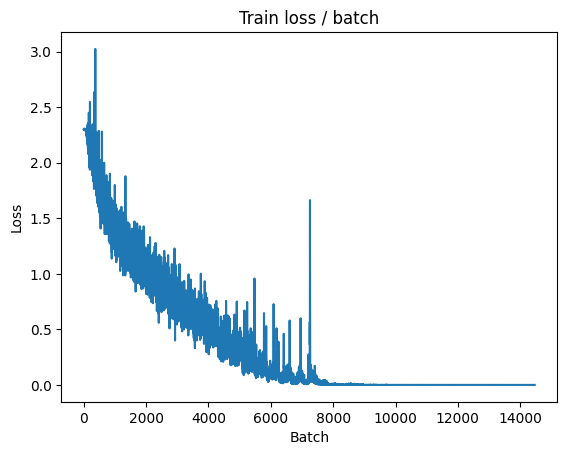

[TRAIN Batch 200/391]	Time 0.006s (0.015s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


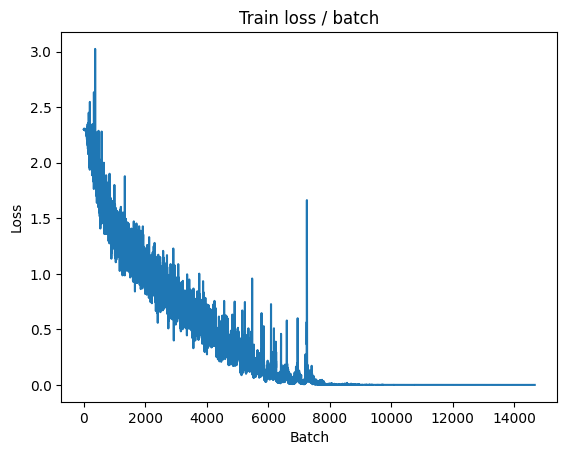


===============> Total time 5s	Avg loss 0.0001	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.092s (0.092s)	Loss 1.8025 (1.8025)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.2403	Avg Prec@1 72.91 %	Avg Prec@5 97.51 %



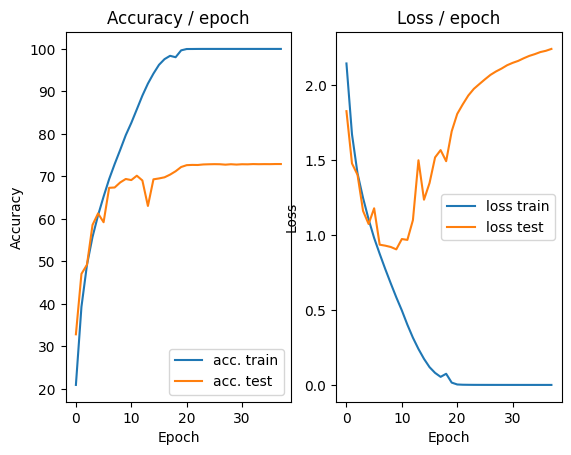

=== EPOCH 39 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


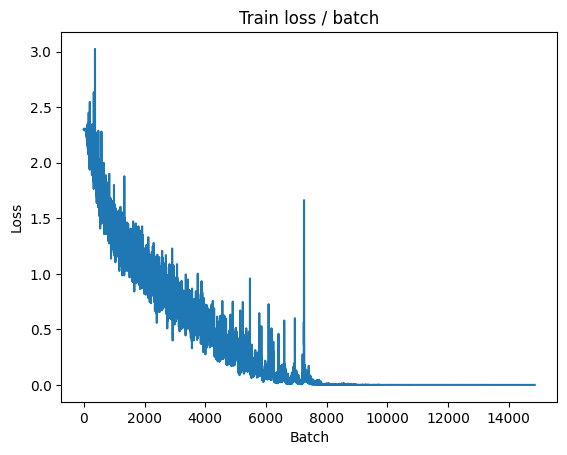

[TRAIN Batch 200/391]	Time 0.014s (0.015s)	Loss 0.0001 (0.0001)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


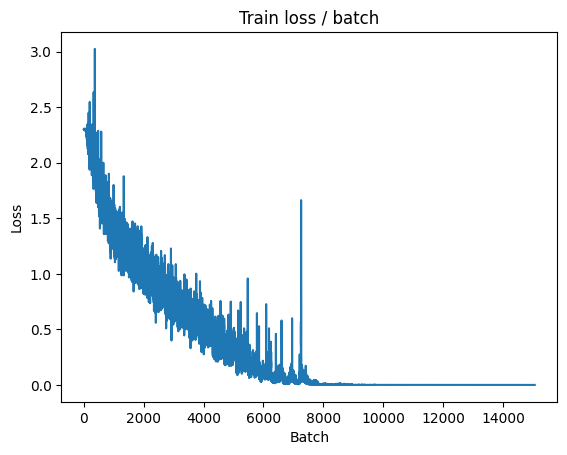


===============> Total time 5s	Avg loss 0.0001	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.092s (0.092s)	Loss 1.8098 (1.8098)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.2526	Avg Prec@1 72.87 %	Avg Prec@5 97.53 %



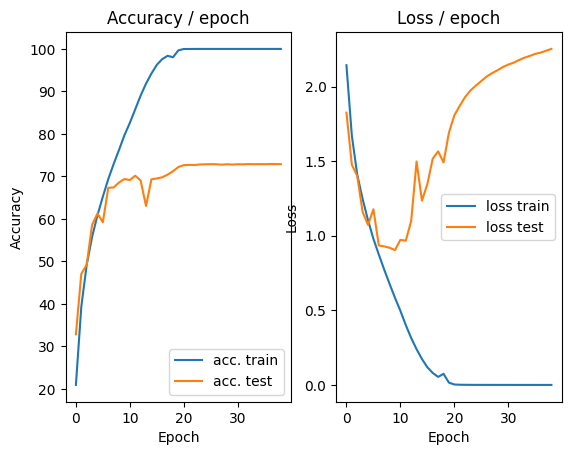

=== EPOCH 40 =====

[TRAIN Batch 000/391]	Time 0.100s (0.100s)	Loss 0.0002 (0.0002)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


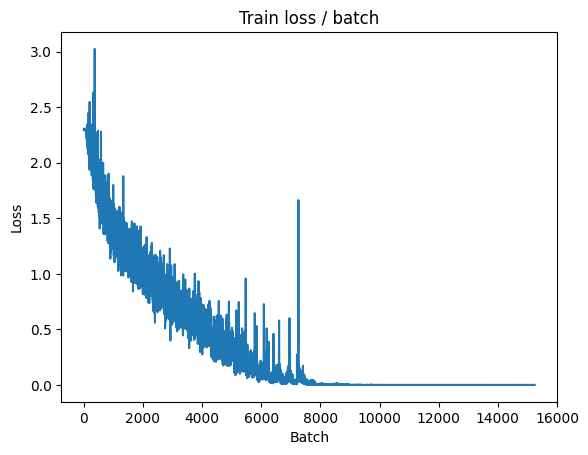

[TRAIN Batch 200/391]	Time 0.020s (0.015s)	Loss 0.0001 (0.0001)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


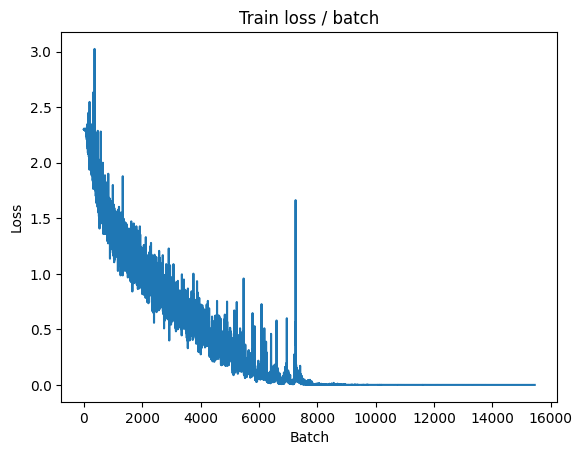


===============> Total time 6s	Avg loss 0.0001	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 1.8170 (1.8170)	Prec@1  71.9 ( 71.9)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 2.2623	Avg Prec@1 72.85 %	Avg Prec@5 97.53 %



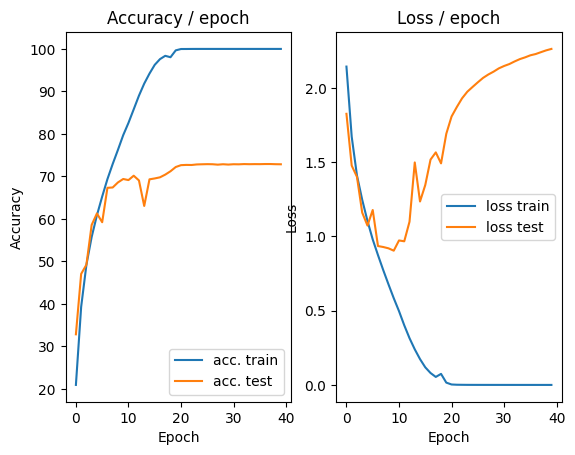

In [22]:
main(128, 0.1, epochs= 40, cuda=True)

We see that as the number of epochs passed through the algorithm increase, the loss converge while having a less erratic behaviour because it gets more occasions to learn and adjust its parameters to the data and getting more performent. 

### Impact of the learning rate

Modification of the predefined functions to not display during iterations

In [6]:
def epoch_output(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates wether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        
    return avg_top1_acc, avg_top5_acc, avg_loss


def main_output(batch_size=128, lr=0.1, epochs=10, cuda=False):

    # Initialize model, loss, optimizer
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # To store the results for later plotting
    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    # Iterate over epochs
    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)
        
        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


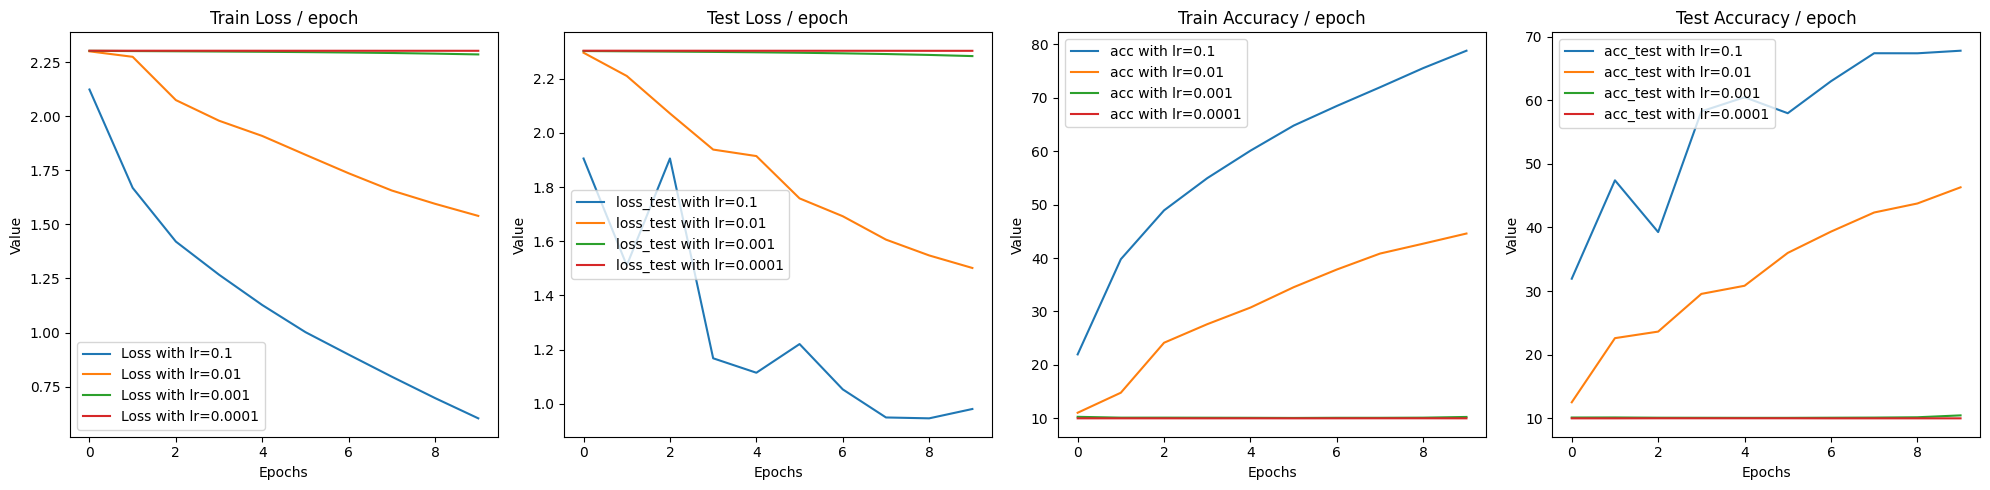

In [7]:
_lr = [1e-1, 1e-2, 1e-3, 1e-4]
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax = ax.flatten()

for val in _lr:
    loss, loss_test, acc, acc_test = main_output(lr=val)
    ax[0].plot(loss, label="Loss with lr="+str(val))
    ax[1].plot(loss_test, label="loss_test with lr="+str(val))
    ax[2].plot(acc, label="acc with lr="+str(val))
    ax[3].plot(acc_test, label="acc_test with lr="+str(val))
    
    ax[0].set_title(f"Train Loss / epoch")
    ax[1].set_title(f"Test Loss / epoch")
    ax[2].set_title(f"Train Accuracy / epoch")
    ax[3].set_title(f"Test Accuracy / epoch")
    
    for a in ax:
        a.legend()
        a.set_xlabel("Epochs")
        a.set_ylabel("Value")
    
plt.tight_layout()

### Impact of the batch_size

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


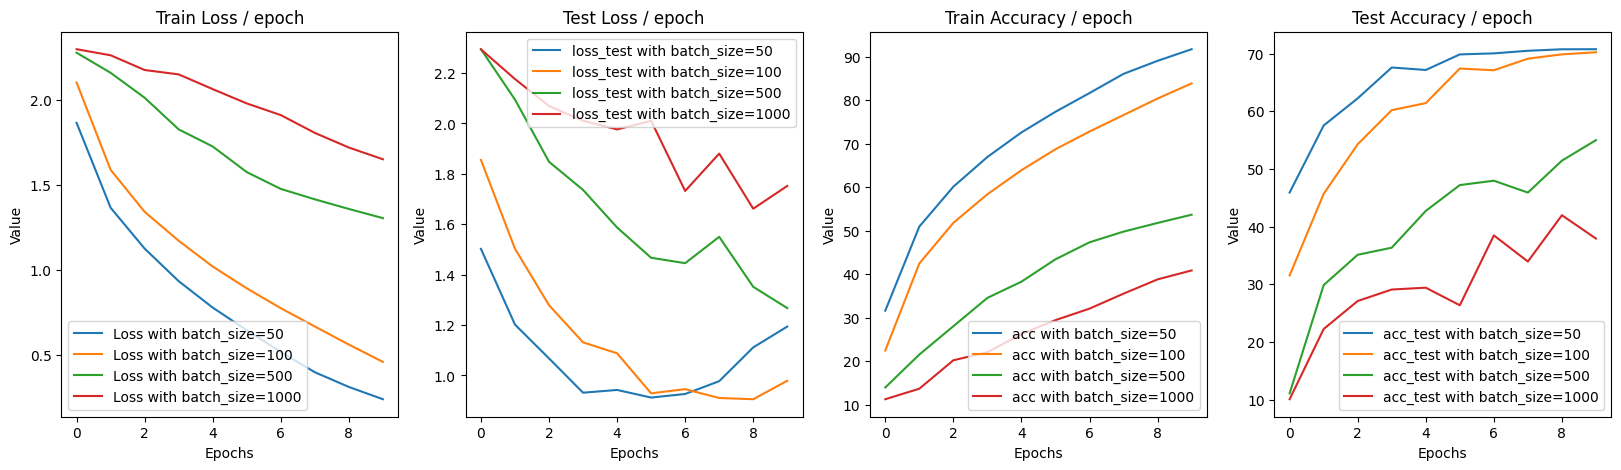

In [8]:
_batch_size = [50, 100, 500, 1000]
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax = ax.flatten()

for val in _batch_size:
    loss, loss_test, acc, acc_test = main_output(batch_size=val, epochs=10,cuda=True)
    ax[0].plot(loss, label="Loss with batch_size="+str(val))
    ax[1].plot(loss_test, label="loss_test with batch_size="+str(val))
    ax[2].plot(acc, label="acc with batch_size="+str(val))
    ax[3].plot(acc_test, label="acc_test with batch_size="+str(val))
    
    ax[0].set_title(f"Train Loss / epoch")
    ax[1].set_title(f"Test Loss / epoch")
    ax[2].set_title(f"Train Accuracy / epoch")
    ax[3].set_title(f"Test Accuracy / epoch")
    
for a in ax:
    a.legend()
    a.set_xlabel("Epochs")
    a.set_ylabel("Value")


# <span style="color:green"> 3. Results improvements

 ## <span style='color:gray'> 3.1 Standardization of example

In [19]:
def get_dataset_normalized(batch_size, cuda=False):
    """
    This function loads the dataset and performs normalization on each
    image.
    """
    mu = torch.tensor([0.491, 0.482, 0.447])
    sigma = torch.tensor([0.202, 0.199, 0.201])
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            #adding the normalisation
            transforms.Normalize(mu, sigma)
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mu,sigma)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

def main(batch_size=128, lr=0.1, epochs=25, cuda=False):

    # Initialize model, loss, optimizer
    model = ConvNet() 
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset_normalized(batch_size, cuda)

    # To store the results for later plotting
    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    # Iterate over epochs
    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)
        
        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values
        

In [20]:
loss_norm, loss_test_norm, top1_acc_norm, top1_acc_test_norm = main()

Files already downloaded and verified
Files already downloaded and verified


Text(0.5, 1.0, 'Accuracy and loss per epoch with data normalization')

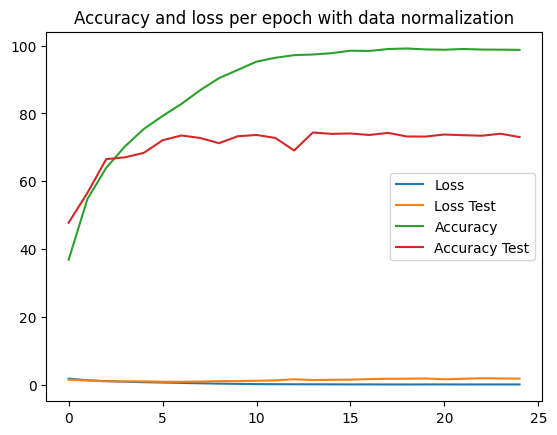

In [21]:
plt.plot(loss_norm, label = "Loss")
plt.plot(loss_test_norm, label = "Loss Test")
plt.plot(top1_acc_norm, label = "Accuracy")
plt.plot(top1_acc_test_norm, label = "Accuracy Test")
plt.legend()
plt.title("Accuracy and loss per epoch with data normalization")

**BONUS**
- ZCA normalisation as a preprocessing method

In [22]:

class ZCATransform:
    def __init__(self, dataset, mu, epsilon=1e-5):
        """
        Initialise la transformation ZCA en calculant la matrice ZCA sur le dataset donné.
        """
        self.mu = mu
        self.epsilon = epsilon
        self.ZCA_matrix = self.compute_zca_matrix(dataset)

    def compute_zca_matrix(self, dataset):
        data = []
        to_tensor = transforms.ToTensor()
        for img, _ in dataset:
            img = to_tensor(img) 
            img = img - self.mu.view(3,1,1)
            data.append(img.view(-1).unsqueeze(0))  # Flatten the images
        data = torch.cat(data)

        # Computation of the ZCA covariance matrix
        cov = torch.matmul(data.T, data) / data.size(0)

        # Singular value decomposition (SVD algorithm) for ZCA
        U, S, V = torch.svd(cov)
        ZCA_matrix = torch.matmul(U, torch.matmul(torch.diag(1.0 / torch.sqrt(S + self.epsilon)), U.T))
        return ZCA_matrix

    def __call__(self, img):
        img = img - self.mu.view(3, 1, 1)  # Centering
        flat_img = img.view(-1)
        zca_img = torch.matmul(self.ZCA_matrix, flat_img)
        return zca_img.view(img.size())
    
    
def get_dataset_normalized_zca(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et applique la normalisation ZCA.
    """
    mu = torch.tensor([0.491, 0.482, 0.447])
    sigma = torch.tensor([0.202, 0.199, 0.201])

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True, transform=None)
    
    # Calculation of the ZCA transformation for train dataset
    zca_transform_train = ZCATransform(train_dataset, mu)
    
    train_dataset.transform = transforms.Compose([
        transforms.ToTensor(),
        zca_transform_train
    ])

    
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True, transform=None)
    
    # Calculation of the ZCA transformation for test dataset
    zca_transform_val = ZCATransform(val_dataset, mu)
    
    val_dataset.transform = transforms.Compose([
        transforms.ToTensor(),
        zca_transform_val
    ])
    
    #  ZCA matrix
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

        
def main_zca(batch_size=128, lr=0.1, epochs=25, cuda=False):

    # Initialize model, loss, optimizer
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset_normalized_zca(batch_size, cuda) ##CHANGED

    # To store the results for later plotting
    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    # Iterate over epochs
    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)
        
        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values

loss_zca, loss_test_zca, top1_acc_zca, top1_acc_test_zca = main_zca()

Files already downloaded and verified
Files already downloaded and verified


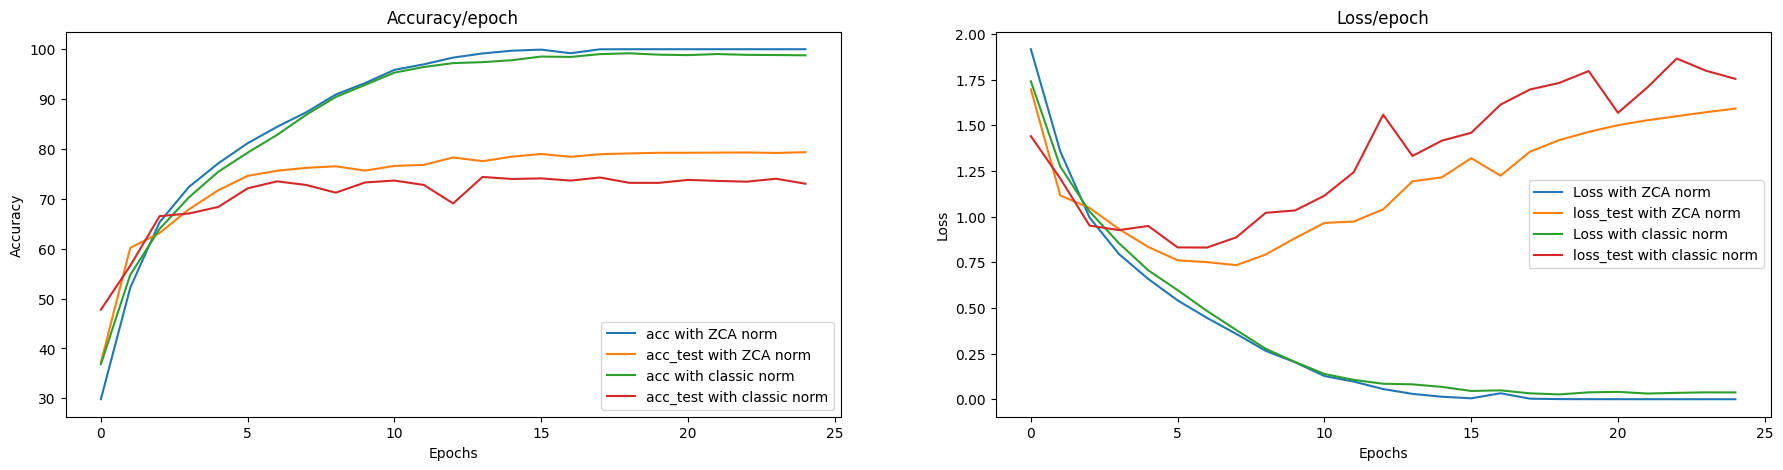

In [24]:
fig, ax = plt.subplots(1,2,figsize=(22,5))
ax = ax.flatten()

ax[0].plot(top1_acc_zca, label="acc with ZCA norm")
ax[0].plot(top1_acc_test_zca, label="acc_test with ZCA norm")
ax[0].plot(top1_acc_norm, label="acc with classic norm")
ax[0].plot(top1_acc_test_norm, label="acc_test with classic norm")
ax[0].set_title("Accuracy/epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(loss_zca, label="Loss with ZCA norm")
ax[1].plot(loss_test_zca, label="loss_test with ZCA norm")
ax[1].plot(loss_norm, label="Loss with classic norm")
ax[1].plot(loss_test_norm, label="loss_test with classic norm")
ax[1].set_title("Loss/epoch")
ax[1].set_ylabel("Loss")

for a in ax:
    a.legend()
    a.set_xlabel("Epochs")

 ## <span style='color:gray'> 3.2 Increase in the number of training examples by data increase

In [51]:
import torch
from torchvision import datasets, transforms

PATH = './datasets'  # Chemin pour le dataset CIFAR10

def get_dataset_increase(batch_size, cuda=False):
    """
    Load the dataset CIFAR10 with the transformations to increase the training data.
    """
    mu = torch.tensor([0.491, 0.482, 0.447])
    sigma = torch.tensor([0.202, 0.199, 0.201])

    # Transformations for the training data set with increase
    train_transform = transforms.Compose([
        transforms.RandomCrop(28),  # Random crop 28x28
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal symmetry with probability of 0.5
        transforms.ToTensor(),
        transforms.Normalize(mu, sigma)
    ])

    # Transformations for the training data set with cropping
    test_transform = transforms.Compose([
        transforms.CenterCrop(28), # Random crop 28x28
        transforms.ToTensor(),
        transforms.Normalize(mu, sigma)
    ])

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True, transform=train_transform)
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader


class ConvNet_increase(nn.Module):
    """
    This class defines the structure of the neural network -> modification
    """

    def __init__(self):
        super(ConvNet_increase, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2), # CONV1
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), # POOL1
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),  # CONV2
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), #POOL2
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2), #CONV3
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True), #POOL3 => adding ceil_mode
            nn.Flatten(), 
        )

        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),  # FC4
            nn.ReLU(),
            nn.Linear(1000, 10),   #FC4
            # Reminder: The softmax is included in the loss, do not put it here
        )

    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output
    
def main_increase(batch_size=128, lr=0.1, epochs=25, cuda=False):

    # Initialize model, loss, optimizer
    model = ConvNet_increase() ## CHANGED
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset_normalized(batch_size, cuda)

    # To store the results for later plotting
    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    # Iterate over epochs
    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)
        
        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values

loss_incr, loss_test_incr, top1_acc_incr, top1_acc_test_incr = main_increase()

Files already downloaded and verified
Files already downloaded and verified


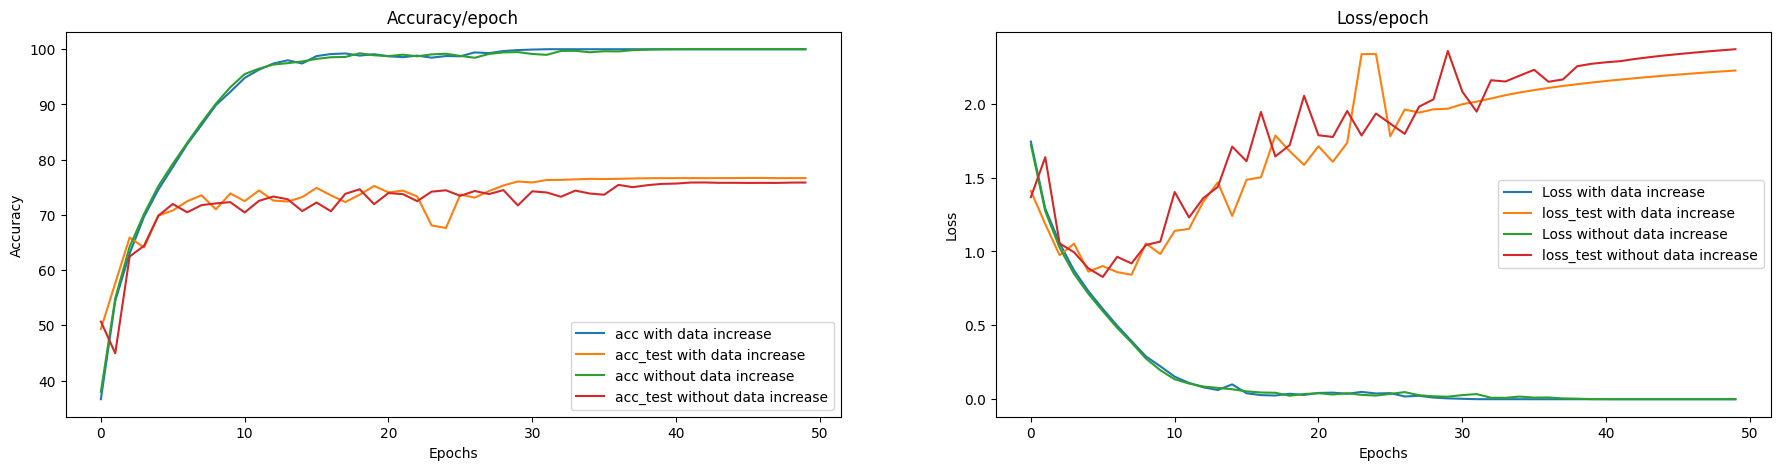

In [54]:
fig, ax = plt.subplots(1,2,figsize=(22,5))
ax = ax.flatten()

ax[1].plot(loss_incr, label="Loss with data increase")
ax[1].plot(loss_test_incr, label="loss_test with data increase")
ax[1].plot(loss_norm, label="Loss without data increase")
ax[1].plot(loss_test_norm, label="loss_test without data increase")
ax[1].set_title("Loss/epoch")
ax[1].set_ylabel("Loss")

ax[0].plot(top1_acc_incr, label="acc with data increase")
ax[0].plot(top1_acc_test_incr, label="acc_test with data increase")
ax[0].plot(top1_acc_norm, label="acc without data increase")
ax[0].plot(top1_acc_test_norm, label="acc_test without data increase")
ax[0].set_title("Accuracy/epoch")
ax[0].set_ylabel("Accuracy")

for a in ax:
    a.legend()
    a.set_xlabel("Epochs")

**BONUS**

Tru other data increase methods, here the Gaussian noise

In [21]:
def get_dataset_gauss(batch_size, cuda=False):
    """
    This function loads the dataset and add a gaussian noise.
    """
    mu = torch.tensor([0.491, 0.482, 0.447])
    sigma = torch.tensor([0.202, 0.199, 0.201])

    # Function to add Gaussian noise
    def add_gaussian_noise(img, mean=0., std=0.1):
        noise = torch.randn_like(img) * std + mean
        return img + noise

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda img: add_gaussian_noise(img)), # Add Gaussian noise
            transforms.Normalize(mu, sigma)
        ]))
    
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def main_gauss(batch_size=128, lr=0.1, epochs=25, cuda=False):

    model = ConvNet() 
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data with noise
    train, test = get_dataset_gauss(batch_size, cuda)

    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)
        
        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values


In [22]:
loss_gauss, loss_test_gauss, top1_acc_gauss, top1_acc_test_gauss = main_gauss()

Files already downloaded and verified
Files already downloaded and verified


Comparing with the previous results:

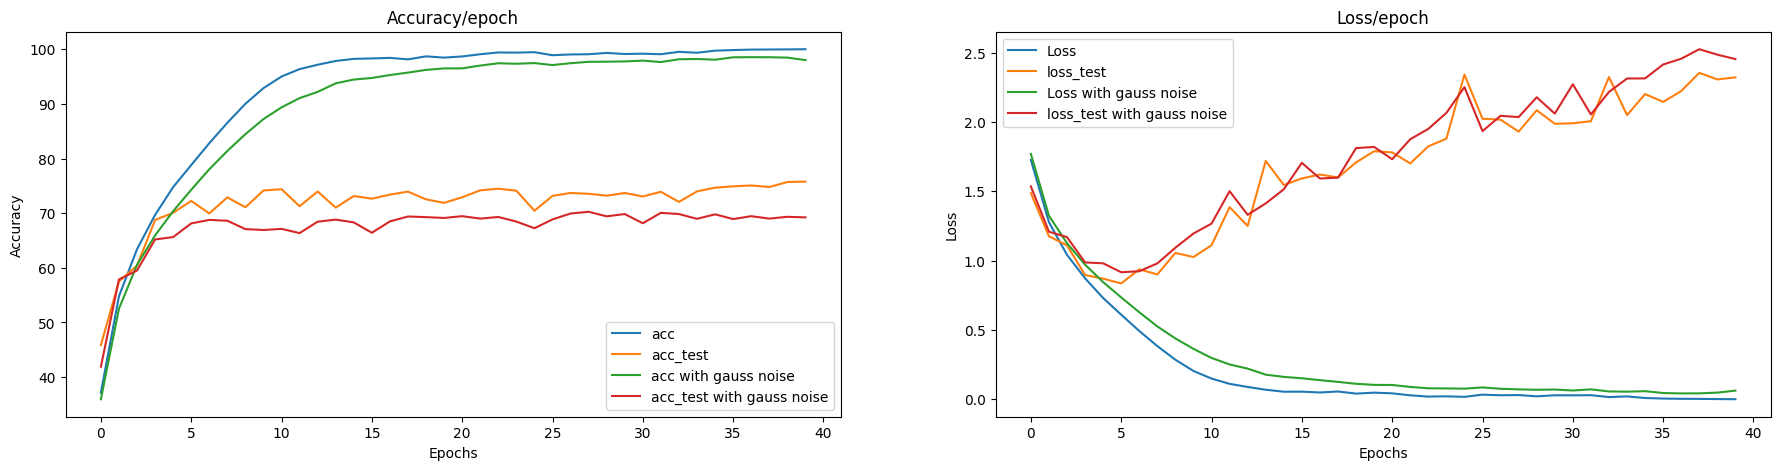

In [24]:
fig, ax = plt.subplots(1,2,figsize=(22,5))
ax = ax.flatten()

ax[1].plot(loss_norm, label="Loss")
ax[1].plot(loss_test_norm, label="loss_test")
ax[1].plot(loss_gauss, label="Loss with gauss noise")
ax[1].plot(loss_test_gauss, label="loss_test with gauss noise")
ax[1].set_title("Loss/epoch")
ax[1].set_ylabel("Loss")

ax[0].plot(top1_acc_norm, label="acc")
ax[0].plot(top1_acc_test_norm, label="acc_test")
ax[0].plot(top1_acc_gauss, label="acc with gauss noise")
ax[0].plot(top1_acc_test_gauss, label="acc_test with gauss noise")
ax[0].set_title("Accuracy/epoch")
ax[0].set_ylabel("Accuracy")

for a in ax:
    a.legend()
    a.set_xlabel("Epochs")

###   <span style="color:green"> 3.3 Variants on the optimization algorithm

In [8]:
def main_lr(batch_size=128, lr=0.1, epochs=25, cuda=False):
    # Define model, loss function, and optimizer
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Add the exponential learning rate scheduler
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda:  # Only use if running on GPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset_normalized(batch_size, cuda)

    
    # To store the results for later plotting
    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    # Training loop
    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)

        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)

        # Step the learning rate scheduler at the end of each epoch
        lr_sched.step()
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values


In [9]:
loss_lr, loss_test_lr, top1_acc_lr, top1_acc_test_lr = main_lr()

Files already downloaded and verified
Files already downloaded and verified


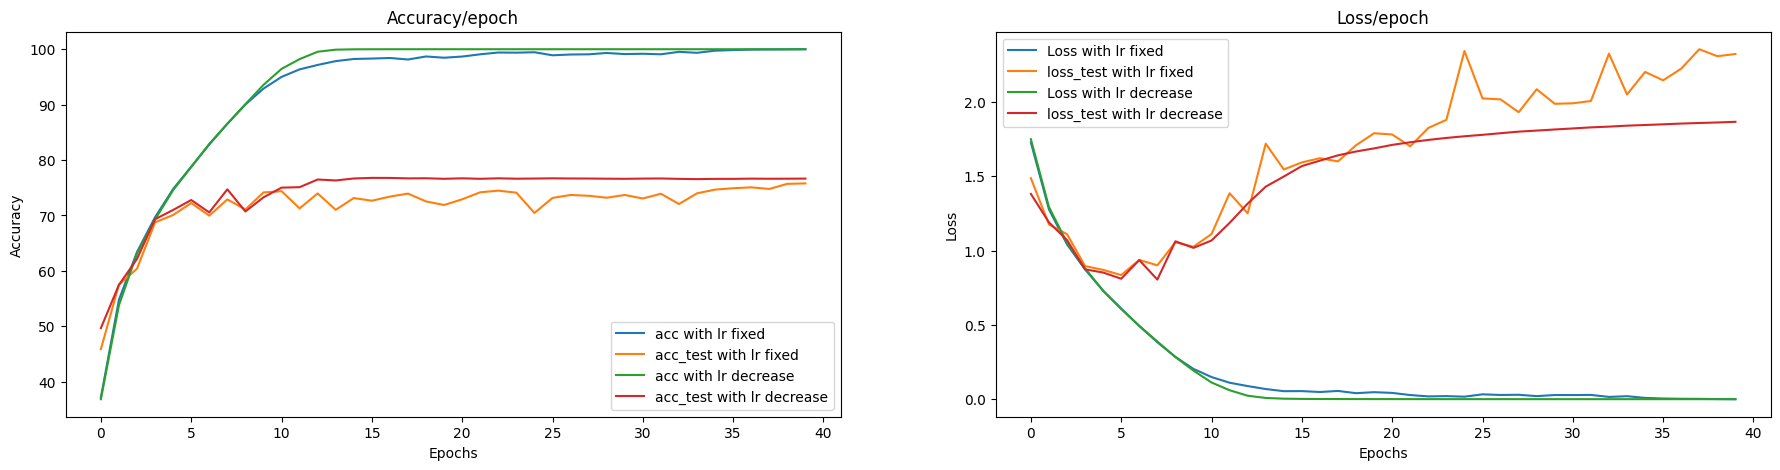

In [20]:
fig, ax = plt.subplots(1,2,figsize=(22,5))
ax = ax.flatten()

ax[0].plot(top1_acc_norm, label="acc with lr fixed")
ax[0].plot(top1_acc_test_norm, label="acc_test with lr fixed")
ax[0].plot(top1_acc_lr, label="acc with lr decrease")
ax[0].plot(top1_acc_test_lr, label="acc_test with lr decrease")
ax[0].set_title("Accuracy/epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(loss_norm, label="Loss with lr fixed")
ax[1].plot(loss_test_norm, label="loss_test with lr fixed")
ax[1].plot(loss_lr, label="Loss with lr decrease")
ax[1].plot(loss_test_lr, label="loss_test with lr decrease")
ax[1].set_title("Loss/epoch")
ax[1].set_ylabel("Loss")

for a in ax:
    a.legend()
    a.set_xlabel("Epochs")

### <span style="color:gray"> 3.4 Regularization of the network by dropout

In [32]:
class ConvNet_dropout(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, p_value=0.5):
        super(ConvNet_dropout, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2), # CONV1
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), # POOL1
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),  # CONV2
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), #POOL2
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2), #CONV3
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0), #POOL3
            nn.Flatten(), # flatten the matrix 64x4x4 in a column vector
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),  # FC4
            nn.ReLU(),
            nn.Dropout(p=p_value),  ##DROPOUT LAYER###
            nn.Linear(1000, 10),   #FC4
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output


def main_dropout(batch_size=128, lr=0.1, epochs=25, cuda=False, p=0.5):

    # Initialize model, loss, optimizer
    model = ConvNet_dropout(p_value=p)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset_normalized(batch_size, cuda)

    # To store the results for later plotting
    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    # Iterate over epochs
    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)
        
        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


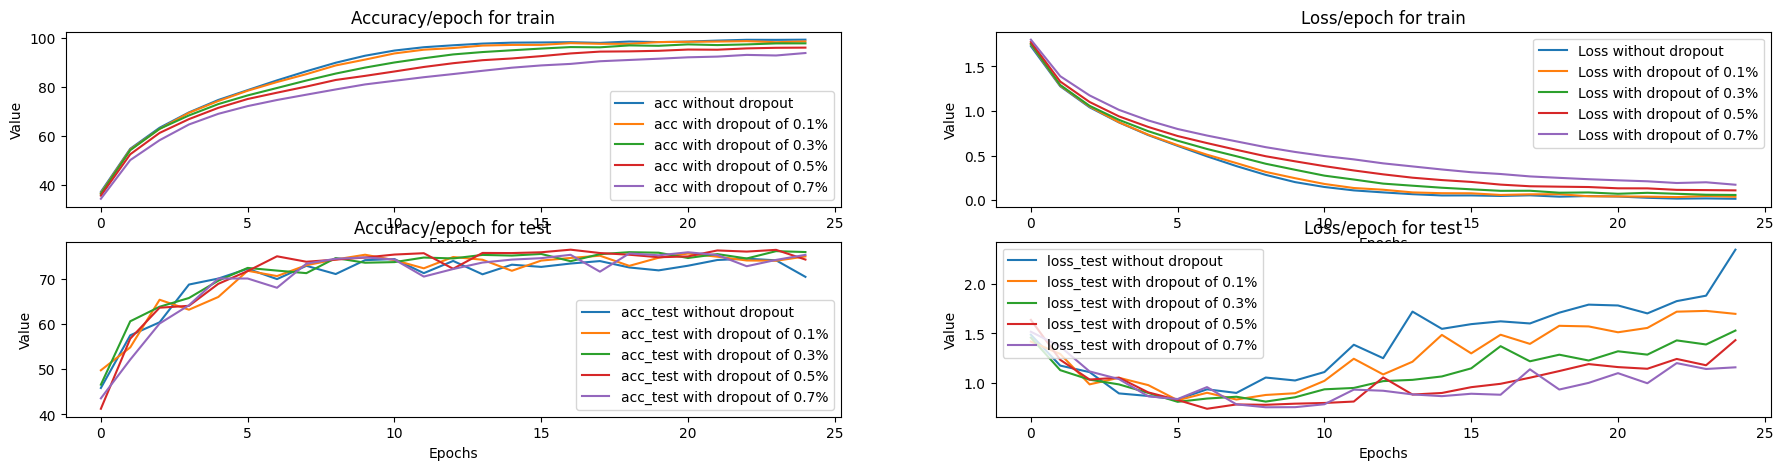

In [33]:
p_values = [0.1, 0.3, 0.5, 0.7]

fig, ax = plt.subplots(2,2,figsize=(20,5))
ax = ax.flatten()

ax[0].plot(top1_acc_norm[:25], label="acc without dropout")
ax[1].plot(loss_norm[:25], label="Loss without dropout")
ax[2].plot(top1_acc_test_norm[:25], label="acc_test without dropout")
ax[3].plot(loss_test_norm[:25], label="loss_test without dropout")
    
ax[0].set_title("Accuracy/epoch for train")
ax[0].set_ylabel("Accuracy")
ax[1].set_title("Loss/epoch for train")
ax[1].set_ylabel("Loss")
ax[2].set_title("Accuracy/epoch for test")
ax[2].set_ylabel("Accuracy")
ax[3].set_title("Loss/epoch for test")
ax[3].set_ylabel("Loss")

for val in p_values:
    
    loss_drop, loss_test_drop, top1_acc_drop, top1_acc_test_drop = main_dropout(p=val)
    
    ax[0].plot(top1_acc_drop, label="acc with dropout of "+str(val*100)+"%")
    ax[1].plot(loss_drop, label="Loss with dropout of "+str(val*100)+"%")
    ax[2].plot(top1_acc_test_drop, label="acc_test with dropout of "+str(val*100)+"%")
    ax[3].plot(loss_test_drop, label="loss_test with dropout of "+str(val*100)+"%")
    
for a in ax:
        a.legend()
        a.set_xlabel("Epochs")


### <span style="color:gray"> 3.5 Use of batch normalization

In [13]:
class ConvNet_batch_norm(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet_batch_norm, self).__init__()
        # Define the convolution, batch normalization, and pooling layers as a feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),  # CONV1
            nn.BatchNorm2d(32),  # BatchNorm after CONV1
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),  # POOL1
            
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),  # CONV2
            nn.BatchNorm2d(64),  # BatchNorm after CONV2
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),  # POOL2
            
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),  # CONV3
            nn.BatchNorm2d(64),  # BatchNorm after CONV3
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),  # POOL3
            
            nn.Flatten()  # Flatten the matrix 64x4x4 into a column vector
        )
        
        # Define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),  # FC4
            nn.ReLU(),
            nn.Linear(1000, 10)  # FC5
            # Reminder: The softmax is included in the loss, so do not add it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # output of the fully connected layers
        return output


In [14]:
def main_batch_norm(batch_size=128, lr=0.1, epochs=25, cuda=False):

    # Initialize model, loss, optimizer
    model = ConvNet_batch_norm()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset_normalized(batch_size, cuda)

    # To store the results for later plotting
    loss_values, loss_test_values, top1_acc_values, top1_acc_test_values = [], [], [], []

    # Iterate over epochs
    for i in range(epochs):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch_output(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch_output(test, model, criterion, cuda=cuda)
        
        # Store results in lists
        loss_values.append(loss.avg)
        loss_test_values.append(loss_test.avg)
        top1_acc_values.append(top1_acc.avg)
        top1_acc_test_values.append(top1_acc_test.avg)
    
    return loss_values, loss_test_values, top1_acc_values, top1_acc_test_values

In [15]:
loss_batch_norm, loss_test_batch_norm, top1_acc_batch_norm, top1_acc_test_batch_norm = main_batch_norm()

100%|██████████| 170498071/170498071 [00:12<00:00, 13980269.16it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified


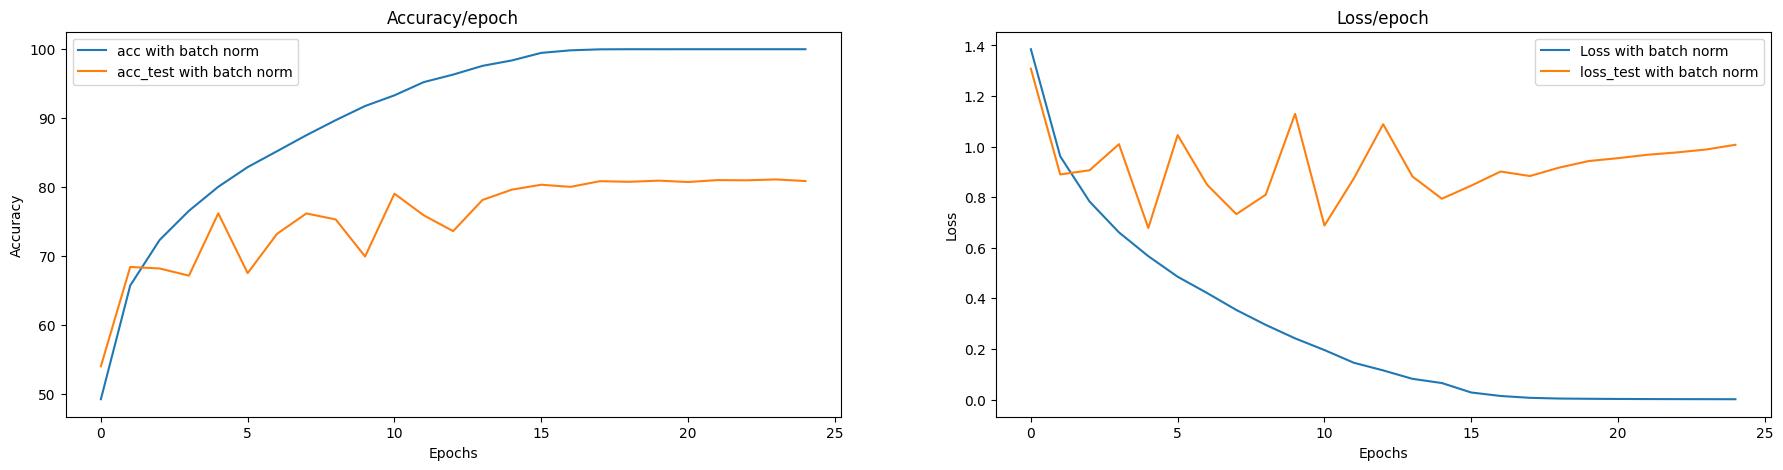

In [18]:
fig, ax = plt.subplots(1,2,figsize=(22,5))
ax = ax.flatten()

ax[0].plot(top1_acc_batch_norm, label="acc with batch norm")
ax[0].plot(top1_acc_test_batch_norm, label="acc_test with batch norm")
ax[0].set_title("Accuracy/epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(loss_batch_norm, label="Loss with batch norm")
ax[1].plot(loss_test_batch_norm, label="loss_test with batch norm")
ax[1].set_title("Loss/epoch")
ax[1].set_ylabel("Loss")

for a in ax:
    a.legend()
    a.set_xlabel("Epochs")